In [2]:
import pandas as pd
import glob
import csv
import numpy as np
from datetime import timedelta
from datetime import datetime
import collections
from collections import Counter
import statistics
import matplotlib.pyplot as plt

In [23]:
### INITIAL DATA CLEANING

# load dataframe
df = pd.read_pickle('../Desktop/saved_dataframes/Store_dataframes.pkl')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at']
df.drop(to_drop, inplace=True, axis=1)

# convert epoch to datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit = 's')
df['deadline'] = pd.to_datetime(df['deadline'], unit = 's')

# calculate duration of the project in months
df['duration'] = (df['deadline'] - df['created_at']) / np.timedelta64(1, 'M')

# convert date to month/year format for created at and deadline
df['Created At Month/Year'] = df['created_at'].apply(lambda x: "%d/%d" % (x.month, x.year))
df['Deadline Month/Year'] = df['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# convert date to month/year format for created at and deadline
df['Created At Year'] = df['created_at'].dt.year
df['Deadline Year'] = df['deadline'].dt.year

# delete live projects (could be cancelled or suspended)
df = df.loc[~(df['state'] == 'live')]

# remove duplicates
df = df.drop_duplicates('id')

# only keep US companies
df = df.loc[~(df['country'] == 'US')]

# Convert Goal to USD
df['goal'] = df['goal'] * df['static_usd_rate']

# Pledged to Goal ratio
df['P/G'] = df['usd_pledged'] / df['goal']

# rearranging columns
df = df[['id','name','creator','category','created_at','Created At Month/Year','Created At Year','deadline','Deadline Month/Year','Deadline Year',
         'duration','goal','usd_pledged', 'P/G','backers_count','state','country', 'static_usd_rate']]


print('Current number of projects 2009-2018: ')
print(len(df))

Current number of projects 2009-2018: 
40639


In [24]:
# Note: pre-2015 data missing static usd rate
df_all = df

In [25]:
### ADDING COLUMNS

# extract creator id
creator_id = []
for c in df_all['creator']:
    # Format: ..."id": _____,...
    if type(c) == str:
        start_idx = c.find('"id":"') + 7
        end_idx = c.index(',', start_idx, len(c)) # first comma after start of id
        creator_id.append(c[start_idx:end_idx])
    else:
        creator_id.append(c['id'])
df_all['creator_id'] = creator_id

# extract category name
category_name = []
for c in df_all['category']:
    if type(c) == str:
        start_idx = c.find('"slug":"') + 8
        end_idx = c.index('"', start_idx, len(c)) # first quote after start of id
        category_name.append(c[start_idx:end_idx])
    else:
        category_name.append(c['slug'])

df_all['category_name'] = category_name

# rearranging columns
df_all = df_all[['id','name','creator','creator_id','category','category_name','created_at','Created At Month/Year','Created At Year','deadline','Deadline Month/Year','Deadline Year',
         'duration','goal','usd_pledged', 'P/G','backers_count','state','country']]

### FUNDED AND UNFUNDED DATAFRAMES

# Extract successful projects
df_success = df_all.loc[(df_all['state'] == 'successful')]
# Extract failed projects
df_fail = df_all.loc[~(df_all['state'] == 'successful')]
# delete failed projects with >1 P/G ratio (bad data)
df_fail = df_fail.loc[~(df_fail['P/G'] >= 1)]

# Overall probability of success
prob_success = len(df_success) / len(df_all)

print('Full dataset:')
print('Current number of projects: ')
print(len(df_all))
print('Current number of funded projects: ')
print(len(df_success))
print('Current number of non-funded projects: ')
print(len(df_fail))
print('Current number of zero-funded projects: ')
print(len(df_fail.loc[df_fail['usd_pledged'] == 0]))
print('Current probability of success: ')
print(len(df_success) / len(df_all))
print('Total funding: ')
print(sum(list(df_success['usd_pledged'])))



Full dataset:
Current number of projects: 
40639
Current number of funded projects: 
17995
Current number of non-funded projects: 
22564
Current number of zero-funded projects: 
5590
Current probability of success: 
0.44280125003075865
Total funding: 
293975120.5396331


In [26]:
from scipy import stats

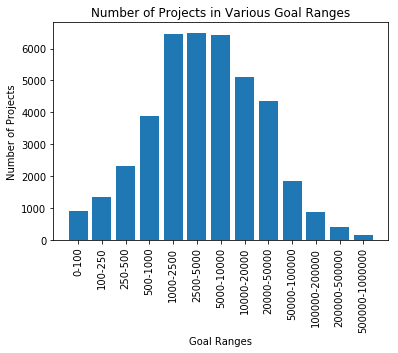

Bar plot values:
{'0-100': 888, '100-250': 1325, '250-500': 2317, '500-1000': 3867, '1000-2500': 6455, '2500-5000': 6500, '5000-10000': 6409, '10000-20000': 5093, '20000-50000': 4360, '50000-100000': 1829, '100000-200000': 866, '200000-500000': 412, '500000-1000000': 147}


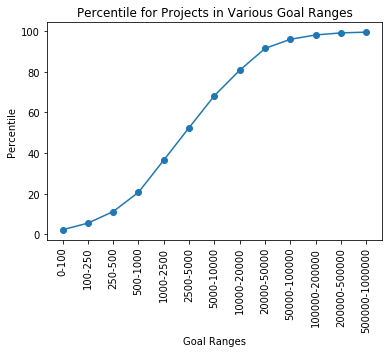

Bar plot values:
{'0-100': 2.1850931371342797, '100-250': 5.445508009547479, '250-500': 11.146927827948522, '500-1000': 20.66241787445557, '1000-2500': 36.54617485666478, '2500-5000': 52.54066291001255, '5000-10000': 68.31122813061344, '10000-20000': 80.84352469302887, '20000-50000': 91.5721351411206, '50000-100000': 96.07273801028569, '100000-200000': 98.20369595708556, '200000-500000': 99.21750043062083, '500000-1000000': 99.57922192967347}


In [27]:
### Testing distribution of goal levels

goal = list(df_all['goal']) # all goal sizes
goal_levels = [0, 100, 250, 500, 1000, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000] # various bounds
goal_num = {} # number of projects in various goal ranges
goal_perc = {} # percentile for various goal ranges

# building dictionary
for i in range(1, len(goal_levels)):
    prev = goal_levels[i - 1]
    curr = goal_levels[i]
    # count number of projects within goal range
    goal_num[str(prev) + '-' + str(curr)] = len(df_all.loc[(df_all['goal'] <= curr) & (df_all['goal'] > prev)])
    goal_perc[str(prev) + '-' + str(curr)] = stats.percentileofscore(goal, curr)

# plotting number of projects in various goal ranges
plt.bar(range(len(goal_num)), list(goal_num.values()), align = 'center')
plt.xticks(range(len(goal_num)), list(goal_num.keys()), rotation = 'vertical')
plt.xlabel('Goal Ranges')
plt.ylabel('Number of Projects')
plt.title('Number of Projects in Various Goal Ranges')
plt.show()
print('Bar plot values:')
print(goal_num)

# plotting percentile for projects in various goal ranges
plt.scatter(list(range(len(goal_perc))), list(goal_perc.values()))
plt.plot(list(range(len(goal_perc))), list(goal_perc.values()))
plt.xticks(range(len(goal_perc)), list(goal_perc.keys()), rotation = 'vertical')
plt.xlabel('Goal Ranges')
plt.ylabel('Percentile')
plt.title('Percentile for Projects in Various Goal Ranges')
plt.show()
print('Bar plot values:')
print(goal_perc)

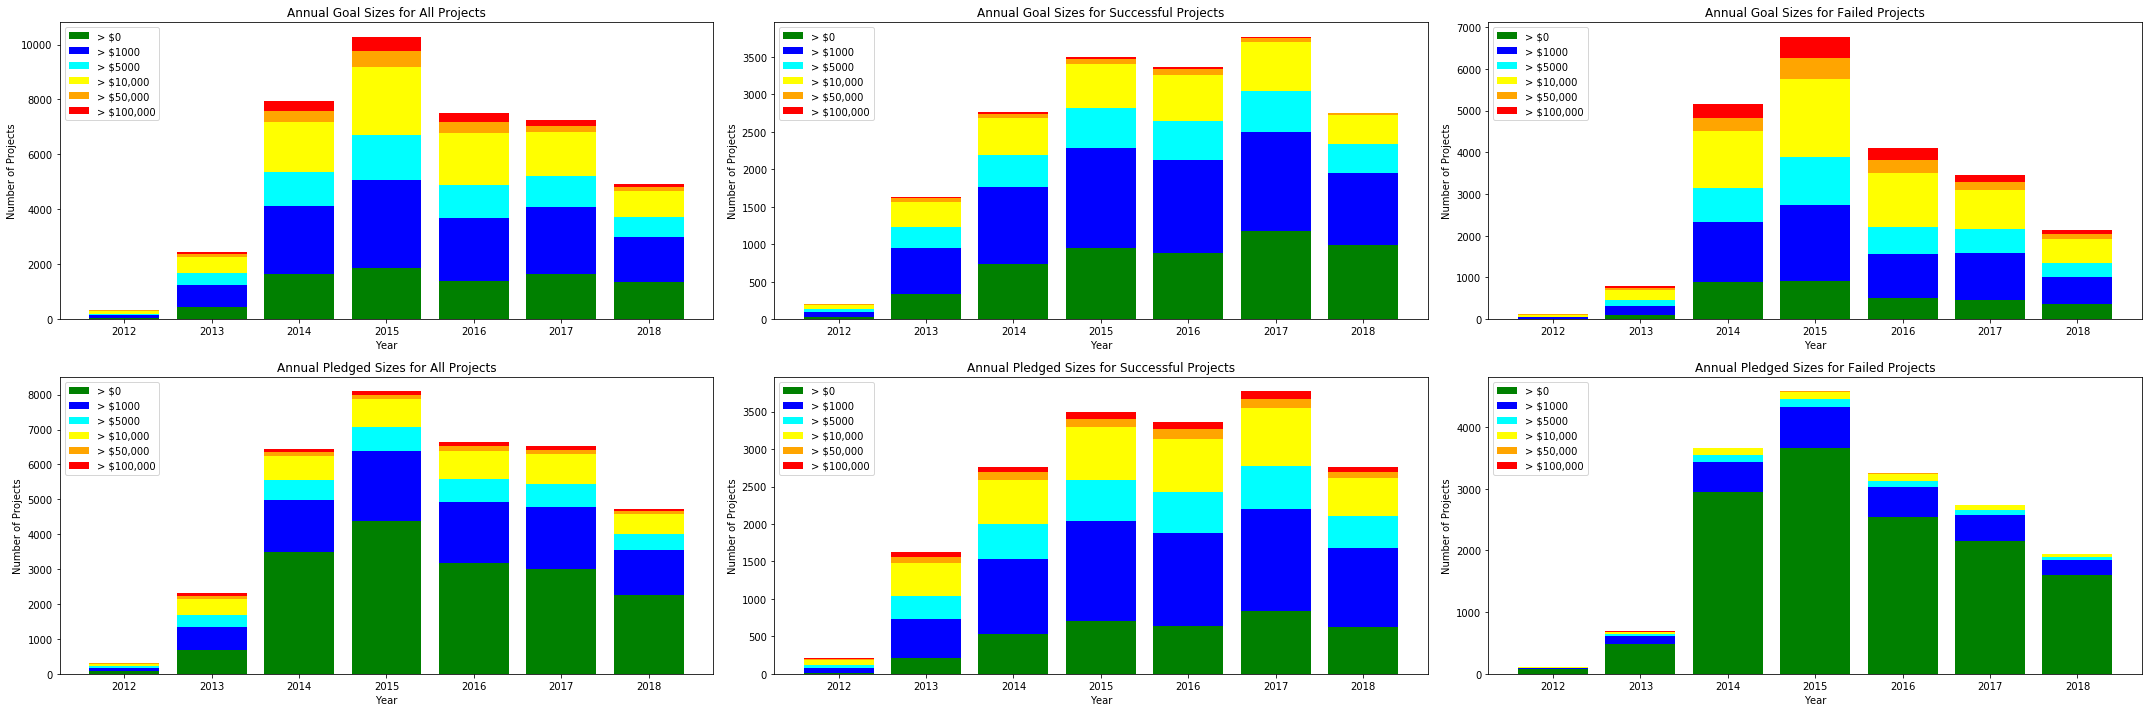

In [28]:
### TESTING DISTRIBUTION OF GOAL SIZES

df_lst = [df_all, df_success, df_fail]
goal_titles = ['Annual Goal Sizes for All Projects', 'Annual Goal Sizes for Successful Projects', 'Annual Goal Sizes for Failed Projects']
pledged_titles = ['Annual Pledged Sizes for All Projects', 'Annual Pledged Sizes for Successful Projects', 'Annual Pledged Sizes for Failed Projects']

fig = plt.figure(figsize = (30,10))

for idx in range(len(df_lst)):
    curr_df = df_lst[idx]
    years = list(curr_df['Created At Year'].drop_duplicates())
    years.sort()

    new_dict = {}
    new_dict_0 = {}
    new_dict_1000 = {}
    new_dict_5000 = {}
    new_dict_10000 = {}
    new_dict_50000 = {}
    new_dict_100000 = {}
    # build dictionaries by putting project in corresponding range
    for i in years:
        temp = curr_df.loc[curr_df['Created At Year'] == i]
        new_dict[i] = list(temp['goal']) # extract goal sizes from each year
        new_dict_0[i] = 0
        new_dict_1000[i] = 0
        new_dict_5000[i] = 0
        new_dict_10000[i] = 0
        new_dict_50000[i] = 0
        new_dict_100000[i] = 0    
    for k, v in new_dict.items():
        for goal in v:
            if goal > 0:
                new_dict_0[k] += 1
            if goal > 1000:
                new_dict_1000[k] += 1
            if goal > 5000:
                new_dict_5000[k] += 1
            if goal > 10000:
                new_dict_10000[k] += 1
            if goal > 50000:
                new_dict_50000[k] += 1
            if goal > 100000:
                new_dict_100000[k] += 1

    lst_0 = np.zeros([len(years)], dtype=int)
    lst_1000 = np.zeros([len(years)], dtype=int)
    lst_5000 = np.zeros([len(years)], dtype=int)
    lst_10000 = np.zeros([len(years)], dtype=int)
    lst_50000 = np.zeros([len(years)], dtype=int)
    lst_100000 = np.zeros([len(years)], dtype=int)
    for i in range(len(years)):
        lst_0[i] = new_dict_0[years[i]] - new_dict_1000[years[i]]
        lst_1000[i] = new_dict_1000[years[i]] - new_dict_5000[years[i]]
        lst_5000[i] = new_dict_5000[years[i]] - new_dict_10000[years[i]]
        lst_10000[i] = new_dict_10000[years[i]] - new_dict_50000[years[i]]
        lst_50000[i] = new_dict_50000[years[i]] - new_dict_100000[years[i]]
        lst_100000[i] = new_dict_100000[years[i]]

    ind = np.arange(len(years))
    plt.subplot(2, 3, idx+1)
    plt.bar(ind, lst_0, width=0.8, label='> $0', color='green')
    plt.bar(ind, lst_1000, width=0.8, label='> $1000', color='blue', bottom=lst_0)
    plt.bar(ind, lst_5000, width=0.8, label='> $5000', color='cyan', bottom=lst_0+lst_1000)
    plt.bar(ind, lst_10000, width=0.8, label='> $10,000', color='yellow', bottom=lst_0+lst_1000+lst_5000)
    plt.bar(ind, lst_50000, width=0.8, label='> $50,000', color='orange', bottom=lst_0+lst_1000+lst_5000+lst_10000)
    plt.bar(ind, lst_100000, width=0.8, label='> $100,000', color='red', bottom=lst_0+lst_1000+lst_5000+lst_10000+lst_50000)

    plt.xticks(ind, years)
    plt.ylabel("Number of Projects")
    plt.xlabel("Year")
    plt.legend(loc="upper left")
    plt.title(goal_titles[idx])
    
for idx in range(len(df_lst)):
    curr_df = df_lst[idx]
    years = list(curr_df['Created At Year'].drop_duplicates())
    years.sort()

    new_dict = {}
    new_dict_0 = {}
    new_dict_1000 = {}
    new_dict_5000 = {}
    new_dict_10000 = {}
    new_dict_50000 = {}
    new_dict_100000 = {}
    # build dictionaries by putting project in corresponding range
    for i in years:
        temp = curr_df.loc[curr_df['Created At Year'] == i]
        new_dict[i] = list(temp['usd_pledged']) # extract goal sizes from each year
        new_dict_0[i] = 0
        new_dict_1000[i] = 0
        new_dict_5000[i] = 0
        new_dict_10000[i] = 0
        new_dict_50000[i] = 0
        new_dict_100000[i] = 0    
    for k, v in new_dict.items():
        for goal in v:
            if goal > 0:
                new_dict_0[k] += 1
            if goal > 1000:
                new_dict_1000[k] += 1
            if goal > 5000:
                new_dict_5000[k] += 1
            if goal > 10000:
                new_dict_10000[k] += 1
            if goal > 50000:
                new_dict_50000[k] += 1
            if goal > 100000:
                new_dict_100000[k] += 1

    lst_0 = np.zeros([len(years)], dtype=int)
    lst_1000 = np.zeros([len(years)], dtype=int)
    lst_5000 = np.zeros([len(years)], dtype=int)
    lst_10000 = np.zeros([len(years)], dtype=int)
    lst_50000 = np.zeros([len(years)], dtype=int)
    lst_100000 = np.zeros([len(years)], dtype=int)
    for i in range(len(years)):
        lst_0[i] = new_dict_0[years[i]] - new_dict_1000[years[i]]
        lst_1000[i] = new_dict_1000[years[i]] - new_dict_5000[years[i]]
        lst_5000[i] = new_dict_5000[years[i]] - new_dict_10000[years[i]]
        lst_10000[i] = new_dict_10000[years[i]] - new_dict_50000[years[i]]
        lst_50000[i] = new_dict_50000[years[i]] - new_dict_100000[years[i]]
        lst_100000[i] = new_dict_100000[years[i]]

    ind = np.arange(len(years))
    plt.subplot(2, 3, idx+4)
    plt.bar(ind, lst_0, width=0.8, label='> $0', color='green')
    plt.bar(ind, lst_1000, width=0.8, label='> $1000', color='blue', bottom=lst_0)
    plt.bar(ind, lst_5000, width=0.8, label='> $5000', color='cyan', bottom=lst_0+lst_1000)
    plt.bar(ind, lst_10000, width=0.8, label='> $10,000', color='yellow', bottom=lst_0+lst_1000+lst_5000)
    plt.bar(ind, lst_50000, width=0.8, label='> $50,000', color='orange', bottom=lst_0+lst_1000+lst_5000+lst_10000)
    plt.bar(ind, lst_100000, width=0.8, label='> $100,000', color='red', bottom=lst_0+lst_1000+lst_5000+lst_10000+lst_50000)

    plt.xticks(ind, years)
    plt.ylabel("Number of Projects")
    plt.xlabel("Year")
    plt.legend(loc="upper left")
    plt.title(pledged_titles[idx])

plt.tight_layout()
plt.show()

In [29]:
print('Minimum Goal: $500') # Percentile: 14.58%
print('Maximum Goal: $50,000') # Percentile: 92.74%

# applying minimum and maximum goal for data subset
df1_all = df_all.loc[(df_all['goal'] > 500) & (df_all['goal'] <= 50000)]
df1_success = df_success.loc[(df_success['goal'] > 500) & (df_success['goal'] <= 50000)]
df1_fail = df_fail.loc[(df_fail['goal'] > 500) & (df_fail['goal'] <= 50000)]
df1_live = df1_all.loc[(df1_all['state'] == 'live')]

print()
print('Adjusted Data Subset after setting $500-$50,000 goal range:')
print('Current number of projects: ')
print(len(df1_all))
print('Current number of funded projects: ')
print(len(df1_success))
print('Current number of non-funded projects: ')
print(len(df1_fail))
print('Current probability of success: ')
print(len(df1_success) / len(df1_all))


Minimum Goal: $500
Maximum Goal: $50,000

Adjusted Data Subset after setting $500-$50,000 goal range:
Current number of projects: 
32684
Current number of funded projects: 
14697
Current number of non-funded projects: 
17942
Current probability of success: 
0.4496695630889732


In [30]:
from datetime import datetime

In [31]:
# See the percentage of live projects per month
month_allprojects = df1_all.groupby(['Created At Month/Year']).size().to_dict() # orders in 'numerical order'
ordered_month_allprojects = dict(sorted(month_allprojects.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)) # orders in 'time order'

month_liveprojects = df1_live.groupby(['Created At Month/Year']).size().to_dict() # orders in 'numerical order'
ordered_month_liveprojects = dict(sorted(month_liveprojects.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)) # orders in 'time order'

ordered_month_liverate = {}
for k in ordered_month_liveprojects.keys():
    ordered_month_liverate[k] = ordered_month_liveprojects[k] / ordered_month_allprojects[k]

# Can't include 10/2018-12/2018 projects because over 50% project outcomes still unknown
# Also remove 4/2009 because of small sample size (< 20 projects)
df2_all = df1_all.loc[~(df1_all['Created At Month/Year'].isin(['4/2009','10/2018', '11/2018', '12/2018'])) & ~(df1_all['state'] == 'live')]
df2_success = df1_success.loc[~(df1_success['Created At Month/Year'].isin(['4/2009','10/2018', '11/2018', '12/2018']))]
df2_fail = df1_fail.loc[~(df1_fail['Created At Month/Year'].isin(['4/2009','10/2018', '11/2018', '12/2018'])) & ~(df1_fail['state'] == 'live')]

# Max duration set to 60 days
df2_all = df2_all.loc[df2_all['duration'] <= 2]
df2_success = df2_success.loc[df2_success['duration'] <= 2]
df2_fail = df2_fail.loc[df2_fail['duration'] <= 2]

print('Adjusted Data Subset:')
print('Current number of projects: ')
print(len(df2_all))
print('Current number of funded projects: ')
print(len(df2_success))
print('Current number of non-funded projects: ')
print(len(df2_fail))
print('Current number of zero-funded projects: ')
print(len(df2_fail.loc[df2_fail['usd_pledged'] == 0]))
print('Current probability of success: ')
print(len(df2_success) / len(df2_all))
print('Total funding: ')
print(sum(list(df2_success['usd_pledged'])))
    

Adjusted Data Subset:
Current number of projects: 
21592
Current number of funded projects: 
8950
Current number of non-funded projects: 
12614
Current number of zero-funded projects: 
3397
Current probability of success: 
0.4145053723601334
Total funding: 
93139384.32170384


In [34]:
from collections import OrderedDict

Note: Webscraper could not extract all projects post 2015 on Kickstarter
Results post 2015 could be skewed positive.


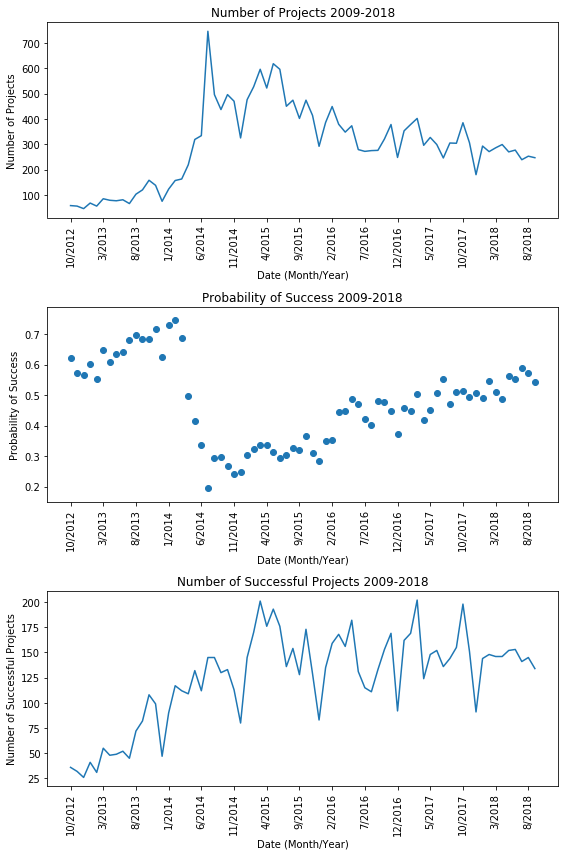

In [35]:
### PLOT NUMBER OF PROJECTS

# sort by date and get number of all projects per month
# key: Month/Year
# value: number of all projects
month_allprojects = df2_all.groupby(['Created At Month/Year']).size().to_dict() # orders in 'numerical order'
ordered_month_allprojects = dict(sorted(month_allprojects.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)) # orders in 'time order'

fig = plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(list(ordered_month_allprojects.keys()), list(ordered_month_allprojects.values()))
locs, labels = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical') # plot every 5 months
plt.xlabel('Date (Month/Year)')
plt.ylabel('Number of Projects')
plt.title('Number of Projects 2009-2018')

### PLOT NUMBER OF SUCCESSFUL PROJECTS

# sort by date and get number of successful projects per month
# key: Month/Year
# value: number of successful projects
month_successprojects = df2_success.groupby(['Created At Month/Year']).size().to_dict()
ordered_month_successprojects = dict(sorted(month_successprojects.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))

plt.subplot(3, 1, 3)
plt.plot(list(ordered_month_successprojects.keys()), list(ordered_month_successprojects.values()))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical')
plt.xlabel('Date (Month/Year)')
plt.ylabel('Number of Successful Projects')
plt.title('Number of Successful Projects 2009-2018')

### NUMBER OF NON-SUCCESSFUL PROJECTS
# sort by date and get number of successful projects per month
# key: Month/Year
# value: number of successful projects
month_failprojects = df2_fail.groupby(['Created At Month/Year']).size().to_dict()
ordered_month_failprojects = dict(sorted(month_failprojects.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))


### PLOT PROBABILITY OF SUCCESS

# key: Month/Year
# value: probability of success per month
ordered_month_probsuccess = {}
for k in ordered_month_successprojects.keys():
    # probability of success = number of successful projects per month / number of all projects per month
    ordered_month_probsuccess[k] = ordered_month_successprojects[k] / ordered_month_allprojects[k]
    
plt.subplot(3, 1, 2)
plt.scatter(list(ordered_month_probsuccess.keys()), list(ordered_month_probsuccess.values()))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical')
plt.xlabel('Date (Month/Year)')
plt.ylabel('Probability of Success')
plt.title('Probability of Success 2009-2018')

plt.tight_layout()

print('Note: Webscraper could not extract all projects post 2015 on Kickstarter')
print('Results post 2015 could be skewed positive.')

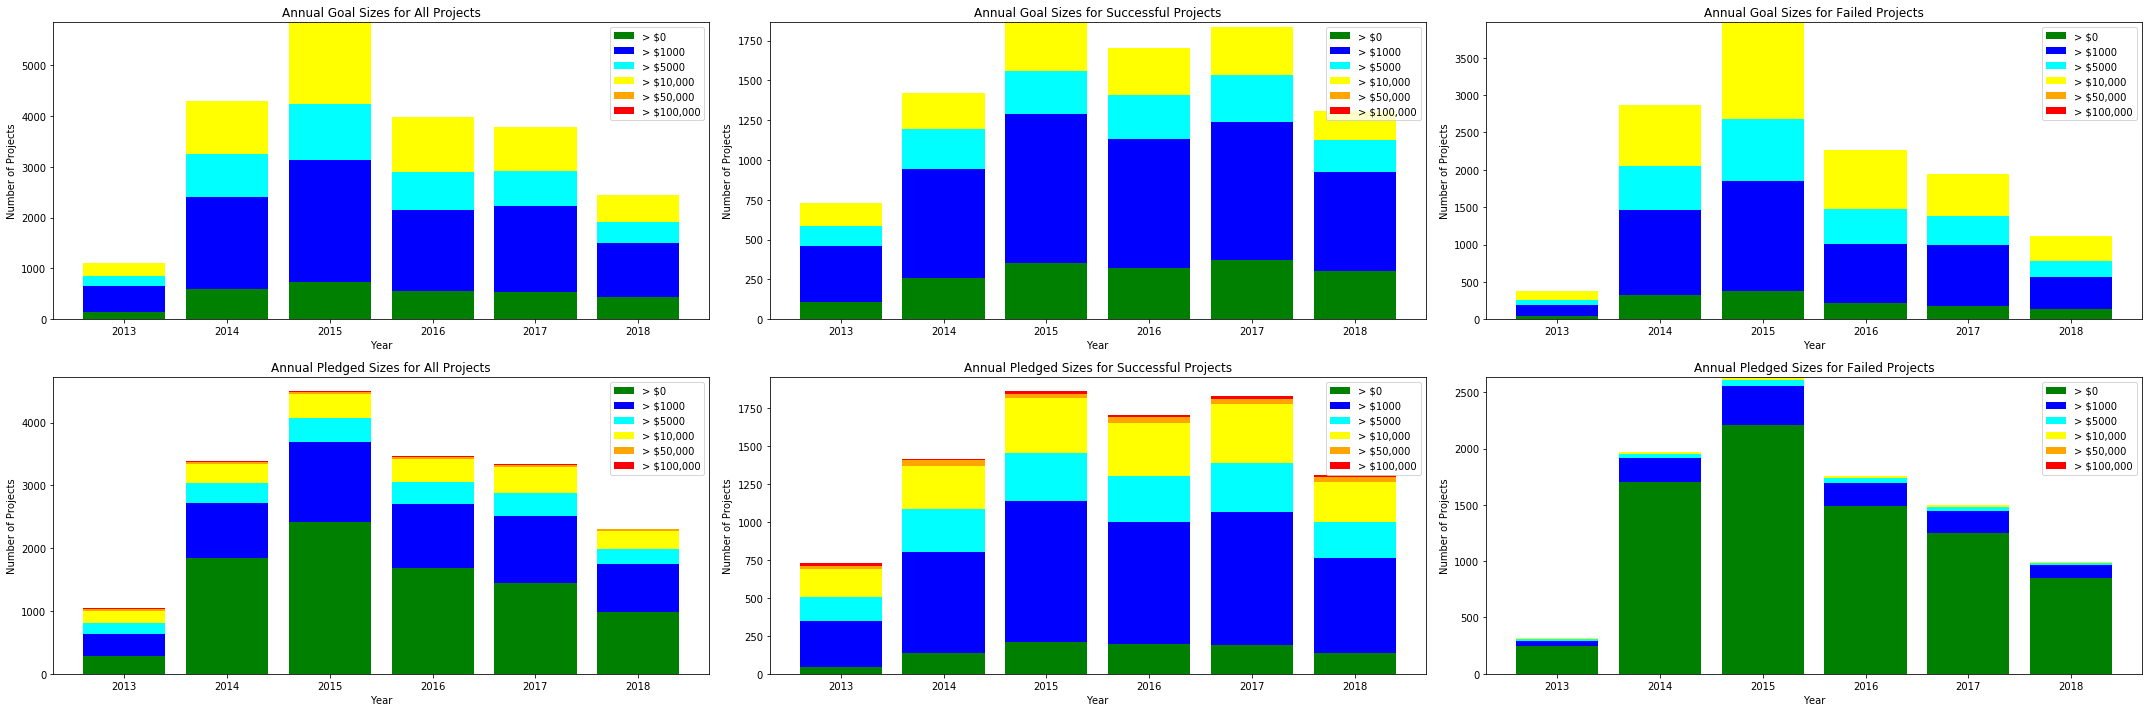

In [36]:
### TESTING DISTRIBUTION OF GOAL SIZES

df_lst = [df2_all, df2_success, df2_fail]
goal_titles = ['Annual Goal Sizes for All Projects', 'Annual Goal Sizes for Successful Projects', 'Annual Goal Sizes for Failed Projects']
pledged_titles = ['Annual Pledged Sizes for All Projects', 'Annual Pledged Sizes for Successful Projects', 'Annual Pledged Sizes for Failed Projects']

fig = plt.figure(figsize = (30,10))

for idx in range(len(df_lst)):
    curr_df = df_lst[idx]
    years = list(curr_df['Created At Year'].drop_duplicates())
    years.sort()
    years = years[1:len(years)]

    new_dict = {}
    new_dict_0 = {}
    new_dict_1000 = {}
    new_dict_5000 = {}
    new_dict_10000 = {}
    new_dict_50000 = {}
    new_dict_100000 = {}
    # build dictionaries by putting project in corresponding range
    for i in years:
        temp = curr_df.loc[curr_df['Created At Year'] == i]
        new_dict[i] = list(temp['goal']) # extract goal sizes from each year
        new_dict_0[i] = 0
        new_dict_1000[i] = 0
        new_dict_5000[i] = 0
        new_dict_10000[i] = 0
        new_dict_50000[i] = 0
        new_dict_100000[i] = 0    
    for k, v in new_dict.items():
        for goal in v:
            if goal > 0:
                new_dict_0[k] += 1
            if goal > 1000:
                new_dict_1000[k] += 1
            if goal > 5000:
                new_dict_5000[k] += 1
            if goal > 10000:
                new_dict_10000[k] += 1
            if goal > 50000:
                new_dict_50000[k] += 1
            if goal > 100000:
                new_dict_100000[k] += 1

    lst_0 = np.zeros([len(years)], dtype=int)
    lst_1000 = np.zeros([len(years)], dtype=int)
    lst_5000 = np.zeros([len(years)], dtype=int)
    lst_10000 = np.zeros([len(years)], dtype=int)
    lst_50000 = np.zeros([len(years)], dtype=int)
    lst_100000 = np.zeros([len(years)], dtype=int)
    for i in range(len(years)):
        lst_0[i] = new_dict_0[years[i]] - new_dict_1000[years[i]]
        lst_1000[i] = new_dict_1000[years[i]] - new_dict_5000[years[i]]
        lst_5000[i] = new_dict_5000[years[i]] - new_dict_10000[years[i]]
        lst_10000[i] = new_dict_10000[years[i]] - new_dict_50000[years[i]]
        lst_50000[i] = new_dict_50000[years[i]] - new_dict_100000[years[i]]
        lst_100000[i] = new_dict_100000[years[i]]

    ind = np.arange(len(years))
    plt.subplot(2, 3, idx+1)
    plt.bar(ind, lst_0, width=0.8, label='> $0', color='green')
    plt.bar(ind, lst_1000, width=0.8, label='> $1000', color='blue', bottom=lst_0)
    plt.bar(ind, lst_5000, width=0.8, label='> $5000', color='cyan', bottom=lst_0+lst_1000)
    plt.bar(ind, lst_10000, width=0.8, label='> $10,000', color='yellow', bottom=lst_0+lst_1000+lst_5000)
    plt.bar(ind, lst_50000, width=0.8, label='> $50,000', color='orange', bottom=lst_0+lst_1000+lst_5000+lst_10000)
    plt.bar(ind, lst_100000, width=0.8, label='> $100,000', color='red', bottom=lst_0+lst_1000+lst_5000+lst_10000+lst_50000)

    plt.xticks(ind, years)
    plt.ylabel("Number of Projects")
    plt.xlabel("Year")
    plt.legend(loc="upper right")
    plt.title(goal_titles[idx])
    
for idx in range(len(df_lst)):
    curr_df = df_lst[idx]
    years = list(curr_df['Created At Year'].drop_duplicates())
    years.sort()
    years = years[1:len(years)]
    
    new_dict = {}
    new_dict_0 = {}
    new_dict_1000 = {}
    new_dict_5000 = {}
    new_dict_10000 = {}
    new_dict_50000 = {}
    new_dict_100000 = {}
    # build dictionaries by putting project in corresponding range
    for i in years:
        temp = curr_df.loc[curr_df['Created At Year'] == i]
        new_dict[i] = list(temp['usd_pledged']) # extract goal sizes from each year
        new_dict_0[i] = 0
        new_dict_1000[i] = 0
        new_dict_5000[i] = 0
        new_dict_10000[i] = 0
        new_dict_50000[i] = 0
        new_dict_100000[i] = 0    
    for k, v in new_dict.items():
        for goal in v:
            if goal > 0:
                new_dict_0[k] += 1
            if goal > 1000:
                new_dict_1000[k] += 1
            if goal > 5000:
                new_dict_5000[k] += 1
            if goal > 10000:
                new_dict_10000[k] += 1
            if goal > 50000:
                new_dict_50000[k] += 1
            if goal > 100000:
                new_dict_100000[k] += 1

    lst_0 = np.zeros([len(years)], dtype=int)
    lst_1000 = np.zeros([len(years)], dtype=int)
    lst_5000 = np.zeros([len(years)], dtype=int)
    lst_10000 = np.zeros([len(years)], dtype=int)
    lst_50000 = np.zeros([len(years)], dtype=int)
    lst_100000 = np.zeros([len(years)], dtype=int)
    for i in range(len(years)):
        lst_0[i] = new_dict_0[years[i]] - new_dict_1000[years[i]]
        lst_1000[i] = new_dict_1000[years[i]] - new_dict_5000[years[i]]
        lst_5000[i] = new_dict_5000[years[i]] - new_dict_10000[years[i]]
        lst_10000[i] = new_dict_10000[years[i]] - new_dict_50000[years[i]]
        lst_50000[i] = new_dict_50000[years[i]] - new_dict_100000[years[i]]
        lst_100000[i] = new_dict_100000[years[i]]

    ind = np.arange(len(years))
    plt.subplot(2, 3, idx+4)
    plt.bar(ind, lst_0, width=0.8, label='> $0', color='green')
    plt.bar(ind, lst_1000, width=0.8, label='> $1000', color='blue', bottom=lst_0)
    plt.bar(ind, lst_5000, width=0.8, label='> $5000', color='cyan', bottom=lst_0+lst_1000)
    plt.bar(ind, lst_10000, width=0.8, label='> $10,000', color='yellow', bottom=lst_0+lst_1000+lst_5000)
    plt.bar(ind, lst_50000, width=0.8, label='> $50,000', color='orange', bottom=lst_0+lst_1000+lst_5000+lst_10000)
    plt.bar(ind, lst_100000, width=0.8, label='> $100,000', color='red', bottom=lst_0+lst_1000+lst_5000+lst_10000+lst_50000)

    plt.xticks(ind, years)
    plt.ylabel("Number of Projects")
    plt.xlabel("Year")
    plt.legend(loc="upper right")
    plt.title(pledged_titles[idx])

plt.tight_layout()
plt.show()

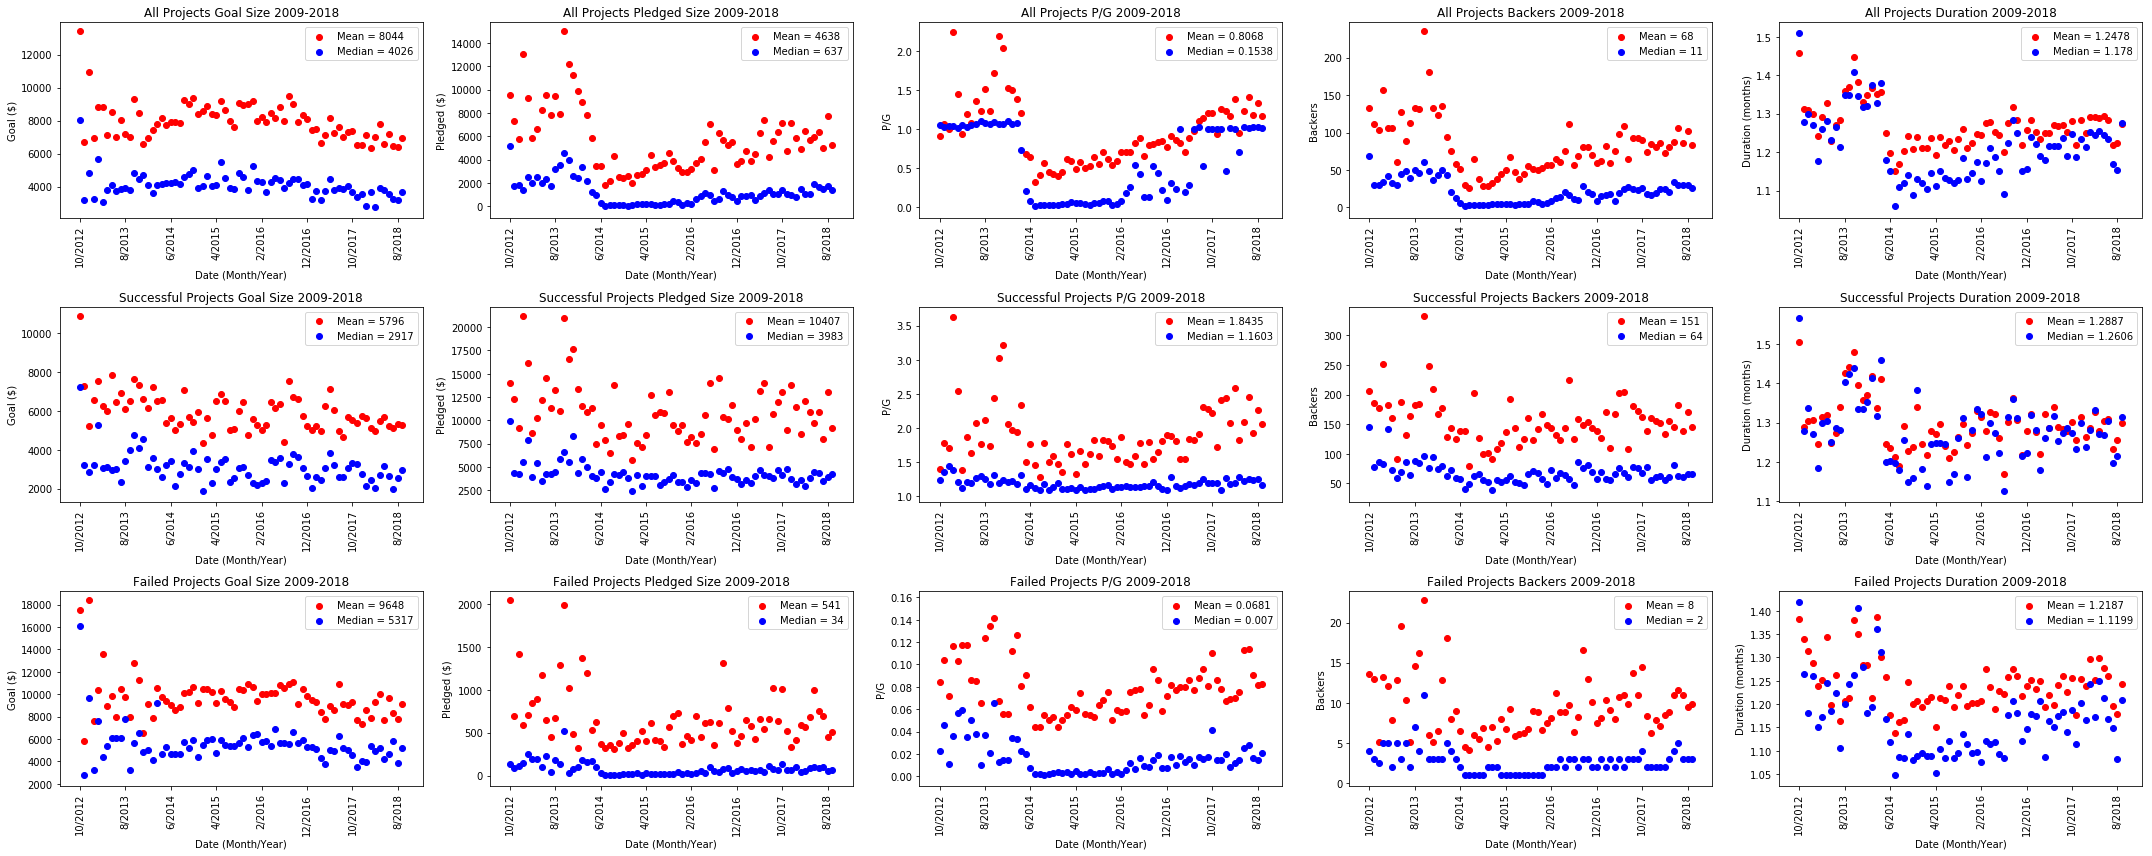

In [37]:
### GOAL AND PLEDGED
### (Note: if division by zero error, run previous cell)
    
### ALL PROJECTS

# key: month/year
# value: goal/pledged size
all_months = list(ordered_month_allprojects.keys())
month_goal_dict = {}
month_pledged_dict = {}
month_pg_dict = {}
month_backers_dict = {}
month_duration_dict = {}
for i in all_months:
    temp = df2_all.loc[df2_all['Created At Month/Year'] == i]
    month_goal_dict[i] = np.array(temp['goal'])
    month_pledged_dict[i] = np.array(temp['usd_pledged'])
    month_pg_dict[i] = month_pledged_dict[i] / month_goal_dict[i]
    month_backers_dict[i] = np.array(temp['backers_count'])
    month_duration_dict[i] = np.array(temp['duration'])

# key: month/year
# value: mean/median goal/pledged
month_meangoal_dict = {} # monthly mean goal size
month_mediangoal_dict = {} # monthly median goal size
for k,v in month_goal_dict.items():
    month_meangoal_dict[k] = sum(v)/ len(v)
    month_mediangoal_dict[k] = statistics.median(v)
month_meanpledged_dict = {} # monthly mean pledged size
month_medianpledged_dict = {} # monthly median pledged size
for k,v in month_pledged_dict.items():
    month_meanpledged_dict[k] = sum(v)/ len(v)
    month_medianpledged_dict[k] = statistics.median(v)
month_meanpg_dict = {} # monthly mean p/g
month_medianpg_dict = {} # monthly median p/g
for k,v in month_pg_dict.items():
    month_meanpg_dict[k] = sum(v)/ len(v)
    month_medianpg_dict[k] = statistics.median(v)
month_meanbackers_dict = {} # monthly mean backers
month_medianbackers_dict = {} # monthly median backers
for k,v in month_backers_dict.items():
    month_meanbackers_dict[k] = sum(v)/ len(v)
    month_medianbackers_dict[k] = statistics.median(v)
month_meanduration_dict = {} # monthly mean duration
month_medianduration_dict = {} # monthly median duration
for k,v in month_duration_dict.items():
    month_meanduration_dict[k] = sum(v)/ len(v)
    month_medianduration_dict[k] = statistics.median(v)

# sort dictionary by time for mean/median dictionaries
ordered_month_meangoal_dict = dict(sorted(month_meangoal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_mediangoal_dict = dict(sorted(month_mediangoal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_meanpledged_dict = dict(sorted(month_meanpledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_medianpledged_dict = dict(sorted(month_medianpledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_meanpg_dict = dict(sorted(month_meanpg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_medianpg_dict = dict(sorted(month_medianpg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_meanbackers_dict = dict(sorted(month_meanbackers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_medianbackers_dict = dict(sorted(month_medianbackers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_meanduration_dict = dict(sorted(month_meanduration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
ordered_month_medianduration_dict = dict(sorted(month_medianduration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))

# PLOT GOAL SIZE
fig = plt.figure(figsize=(30, 12))
plt.subplot(3, 5, 1)
plt.scatter(list(ordered_month_meangoal_dict.keys()), list(ordered_month_meangoal_dict.values()), color = 'red')
plt.scatter(list(ordered_month_mediangoal_dict.keys()), list(ordered_month_mediangoal_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Goal ($)')

mean_goal = sum(df2_all['goal']) / len(df2_all['goal'])
median_goal = statistics.median(df2_all['goal'])
plt.legend(['Mean = ' + str(round(mean_goal)), 
            'Median = ' + str(round(median_goal))])
plt.title('All Projects Goal Size 2009-2018')

# PLOT PLEDGED SIZE
plt.subplot(3, 5, 2)
plt.scatter(list(ordered_month_meanpledged_dict.keys()), list(ordered_month_meanpledged_dict.values()), color = 'red')
plt.scatter(list(ordered_month_medianpledged_dict.keys()), list(ordered_month_medianpledged_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Pledged ($)')

mean_pledged = sum(df2_all['usd_pledged']) / len(df2_all['usd_pledged'])
median_pledged = statistics.median(df2_all['usd_pledged'])
plt.legend(['Mean = ' + str(round(mean_pledged)), 
            'Median = ' + str(round(median_pledged))])
plt.title('All Projects Pledged Size 2009-2018')

# PLOT P/G SIZE
plt.subplot(3, 5, 3)
plt.scatter(list(ordered_month_meanpg_dict.keys()), list(ordered_month_meanpg_dict.values()), color = 'red')
plt.scatter(list(ordered_month_medianpg_dict.keys()), list(ordered_month_medianpg_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('P/G')

mean_pg = sum(df2_all['P/G']) / len(df2_all['P/G'])
median_pg = statistics.median(df2_all['P/G'])
plt.legend(['Mean = ' + str(round(mean_pg, 4)), 
            'Median = ' + str(round(median_pg, 4))])
plt.title('All Projects P/G 2009-2018')

# PLOT BACKERS SIZE
plt.subplot(3, 5, 4)
plt.scatter(list(ordered_month_meanbackers_dict.keys()), list(ordered_month_meanbackers_dict.values()), color = 'red')
plt.scatter(list(ordered_month_medianbackers_dict.keys()), list(ordered_month_medianbackers_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Backers')

mean_backers = sum(df2_all['backers_count']) / len(df2_all['backers_count'])
median_backers = statistics.median(df2_all['backers_count'])
plt.legend(['Mean = ' + str(round(mean_backers)), 
            'Median = ' + str(round(median_backers))])
plt.title('All Projects Backers 2009-2018')

# PLOT DURATION SIZE
plt.subplot(3, 5, 5)
plt.scatter(list(ordered_month_meanduration_dict.keys()), list(ordered_month_meanduration_dict.values()), color = 'red')
plt.scatter(list(ordered_month_medianduration_dict.keys()), list(ordered_month_medianduration_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Duration (months)')

mean_duration = sum(df2_all['duration']) / len(df2_all['duration'])
median_duration = statistics.median(df2_all['duration'])
plt.legend(['Mean = ' + str(round(mean_duration, 4)), 
            'Median = ' + str(round(median_duration, 4))])
plt.title('All Projects Duration 2009-2018')


# --------------------------------------------------
# --------------------------------------------------

### SUCCESSFUL PROJECTS

# key: month/year
# value: goal/pledged size
success_months = list(ordered_month_successprojects.keys())
success_month_goal_dict = {}
success_month_pledged_dict = {}
success_month_pg_dict = {}
success_month_backers_dict = {}
success_month_duration_dict = {}
for i in success_months:
    temp = df2_success.loc[df2_success['Created At Month/Year'] == i]
    success_month_goal_dict[i] = np.array(temp['goal'])
    success_month_pledged_dict[i] = np.array(temp['usd_pledged'])
    success_month_pg_dict[i] = success_month_pledged_dict[i] / success_month_goal_dict[i]
    success_month_backers_dict[i] = np.array(temp['backers_count'])
    success_month_duration_dict[i] = np.array(temp['duration'])

# key: month/year
# value: mean/median goal/pledged
success_month_meangoal_dict = {} # monthly mean goal size
success_month_mediangoal_dict = {} # monthly median goal size
for k,v in success_month_goal_dict.items():
    success_month_meangoal_dict[k] = sum(v)/ len(v)
    success_month_mediangoal_dict[k] = statistics.median(v)
success_month_meanpledged_dict = {} # monthly mean pledged size
success_month_medianpledged_dict = {} # monthly median pledged size
for k,v in success_month_pledged_dict.items():
    success_month_meanpledged_dict[k] = sum(v)/ len(v)
    success_month_medianpledged_dict[k] = statistics.median(v)
success_month_meanpg_dict = {} # monthly mean p/g
success_month_medianpg_dict = {} # monthly median p/g
for k,v in success_month_pg_dict.items():
    success_month_meanpg_dict[k] = sum(v)/ len(v)
    success_month_medianpg_dict[k] = statistics.median(v)
success_month_meanbackers_dict = {} # monthly mean backers
success_month_medianbackers_dict = {} # monthly median backers
for k,v in success_month_backers_dict.items():
    success_month_meanbackers_dict[k] = sum(v)/ len(v)
    success_month_medianbackers_dict[k] = statistics.median(v)
success_month_meanduration_dict = {} # monthly mean duration
success_month_medianduration_dict = {} # monthly median duration
for k,v in success_month_duration_dict.items():
    success_month_meanduration_dict[k] = sum(v)/ len(v)
    success_month_medianduration_dict[k] = statistics.median(v)
    
# sort dictionary by time for mean/median dictionaries
success_ordered_month_meangoal_dict = dict(sorted(success_month_meangoal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_mediangoal_dict = dict(sorted(success_month_mediangoal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_meanpledged_dict = dict(sorted(success_month_meanpledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_medianpledged_dict = dict(sorted(success_month_medianpledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_meanpg_dict = dict(sorted(success_month_meanpg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_medianpg_dict = dict(sorted(success_month_medianpg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_meanbackers_dict = dict(sorted(success_month_meanbackers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_medianbackers_dict = dict(sorted(success_month_medianbackers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_meanduration_dict = dict(sorted(success_month_meanduration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
success_ordered_month_medianduration_dict = dict(sorted(success_month_medianduration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))

# PLOT GOAL SIZE
plt.subplot(3, 5, 6)
plt.scatter(list(success_ordered_month_meangoal_dict.keys()), list(success_ordered_month_meangoal_dict.values()), color = 'red')
plt.scatter(list(success_ordered_month_mediangoal_dict.keys()), list(success_ordered_month_mediangoal_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Goal ($)')

success_mean_goal = sum(df2_success['goal']) / len(df2_success['goal'])
success_median_goal = statistics.median(df2_success['goal'])
plt.legend(['Mean = ' + str(round(success_mean_goal)), 
            'Median = ' + str(round(success_median_goal))])
plt.title('Successful Projects Goal Size 2009-2018')

# PLOT PLEDGED SIZE
plt.subplot(3, 5, 7)
plt.scatter(list(success_ordered_month_meanpledged_dict.keys()), list(success_ordered_month_meanpledged_dict.values()), color = 'red')
plt.scatter(list(success_ordered_month_medianpledged_dict.keys()), list(success_ordered_month_medianpledged_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Pledged ($)')

success_mean_pledged = sum(df2_success['usd_pledged']) / len(df2_success['usd_pledged'])
success_median_pledged = statistics.median(df2_success['usd_pledged'])
plt.legend(['Mean = ' + str(round(success_mean_pledged)), 
            'Median = ' + str(round(success_median_pledged))])
plt.title('Successful Projects Pledged Size 2009-2018')

# PLOT P/G SIZE
plt.subplot(3, 5, 8)
plt.scatter(list(success_ordered_month_meanpg_dict.keys()), list(success_ordered_month_meanpg_dict.values()), color = 'red')
plt.scatter(list(success_ordered_month_medianpg_dict.keys()), list(success_ordered_month_medianpg_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('P/G')

success_mean_pg = sum(df2_success['P/G']) / len(df2_success['P/G'])
success_median_pg = statistics.median(df2_success['P/G'])
plt.legend(['Mean = ' + str(round(success_mean_pg, 4)), 
            'Median = ' + str(round(success_median_pg, 4))])
plt.title('Successful Projects P/G 2009-2018')

# PLOT BACKERS SIZE
plt.subplot(3, 5, 9)
plt.scatter(list(success_ordered_month_meanbackers_dict.keys()), list(success_ordered_month_meanbackers_dict.values()), color = 'red')
plt.scatter(list(success_ordered_month_medianbackers_dict.keys()), list(success_ordered_month_medianbackers_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Backers')

success_mean_backers = sum(df2_success['backers_count']) / len(df2_success['backers_count'])
success_median_backers = statistics.median(df2_success['backers_count'])
plt.legend(['Mean = ' + str(round(success_mean_backers)), 
            'Median = ' + str(round(success_median_backers))])
plt.title('Successful Projects Backers 2009-2018')

# PLOT DURATION SIZE
plt.subplot(3, 5, 10)
plt.scatter(list(success_ordered_month_meanduration_dict.keys()), list(success_ordered_month_meanduration_dict.values()), color = 'red')
plt.scatter(list(success_ordered_month_medianduration_dict.keys()), list(success_ordered_month_medianduration_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Duration (months)')

success_mean_duration = sum(df2_success['duration']) / len(df2_success['duration'])
success_median_duration = statistics.median(df2_success['duration'])
plt.legend(['Mean = ' + str(round(success_mean_duration, 4)), 
            'Median = ' + str(round(success_median_duration, 4))])
plt.title('Successful Projects Duration 2009-2018')

# --------------------------------------------------
# --------------------------------------------------

### NON-SUCCESSFUL PROJECTS

# key: month/year
# value: goal/pledged size
fail_months = list(ordered_month_failprojects.keys())
fail_month_goal_dict = {}
fail_month_pledged_dict = {}
fail_month_pg_dict = {}
fail_month_backers_dict = {}
fail_month_duration_dict = {}
for i in fail_months:
    temp = df2_fail.loc[df2_fail['Created At Month/Year'] == i]
    fail_month_goal_dict[i] = np.array(temp['goal'])
    fail_month_pledged_dict[i] = np.array(temp['usd_pledged'])
    fail_month_pg_dict[i] = fail_month_pledged_dict[i] / fail_month_goal_dict[i]
    fail_month_backers_dict[i] = np.array(temp['backers_count'])
    fail_month_duration_dict[i] = np.array(temp['duration'])

# key: month/year
# value: mean/median goal/pledged
fail_month_meangoal_dict = {} # monthly mean goal size
fail_month_mediangoal_dict = {} # monthly median goal size
for k,v in fail_month_goal_dict.items():
    fail_month_meangoal_dict[k] = sum(v)/ len(v)
    fail_month_mediangoal_dict[k] = statistics.median(v)
fail_month_meanpledged_dict = {} # monthly mean pledged size
fail_month_medianpledged_dict = {} # monthly median pledged size
for k,v in fail_month_pledged_dict.items():
    fail_month_meanpledged_dict[k] = sum(v)/ len(v)
    fail_month_medianpledged_dict[k] = statistics.median(v)
fail_month_meanpg_dict = {} # monthly mean p/g
fail_month_medianpg_dict = {} # monthly median p/g
for k,v in fail_month_pg_dict.items():
    fail_month_meanpg_dict[k] = sum(v)/ len(v)
    fail_month_medianpg_dict[k] = statistics.median(v)
fail_month_meanbackers_dict = {} # monthly mean backers
fail_month_medianbackers_dict = {} # monthly median backers
for k,v in fail_month_backers_dict.items():
    fail_month_meanbackers_dict[k] = sum(v)/ len(v)
    fail_month_medianbackers_dict[k] = statistics.median(v)
fail_month_meanduration_dict = {} # monthly mean duration
fail_month_medianduration_dict = {} # monthly median duration
for k,v in fail_month_duration_dict.items():
    fail_month_meanduration_dict[k] = sum(v)/ len(v)
    fail_month_medianduration_dict[k] = statistics.median(v)

# sort dictionary by time for mean/median dictionaries
fail_ordered_month_meangoal_dict = dict(sorted(fail_month_meangoal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_mediangoal_dict = dict(sorted(fail_month_mediangoal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_meanpledged_dict = dict(sorted(fail_month_meanpledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_medianpledged_dict = dict(sorted(fail_month_medianpledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_meanpg_dict = dict(sorted(fail_month_meanpg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_medianpg_dict = dict(sorted(fail_month_medianpg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_meanbackers_dict = dict(sorted(fail_month_meanbackers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_medianbackers_dict = dict(sorted(fail_month_medianbackers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_meanduration_dict = dict(sorted(fail_month_meanduration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
fail_ordered_month_medianduration_dict = dict(sorted(fail_month_medianduration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))

# PLOT GOAL SIZE
plt.subplot(3, 5, 11)
plt.scatter(list(fail_ordered_month_meangoal_dict.keys()), list(fail_ordered_month_meangoal_dict.values()), color = 'red')
plt.scatter(list(fail_ordered_month_mediangoal_dict.keys()), list(fail_ordered_month_mediangoal_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Goal ($)')

fail_mean_goal = sum(df2_fail['goal']) / len(df2_fail['goal'])
fail_median_goal = statistics.median(df2_fail['goal'])
plt.legend(['Mean = ' + str(round(fail_mean_goal)), 
            'Median = ' + str(round(fail_median_goal))])
plt.title('Failed Projects Goal Size 2009-2018')

# PLOT PLEDGED SIZE
plt.subplot(3, 5, 12)
plt.scatter(list(fail_ordered_month_meanpledged_dict.keys()), list(fail_ordered_month_meanpledged_dict.values()), color = 'red')
plt.scatter(list(fail_ordered_month_medianpledged_dict.keys()), list(fail_ordered_month_medianpledged_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Pledged ($)')

fail_mean_pledged = sum(df2_fail['usd_pledged']) / len(df2_fail['usd_pledged'])
fail_median_pledged = statistics.median(df2_fail['usd_pledged'])
plt.legend(['Mean = ' + str(round(fail_mean_pledged)), 
            'Median = ' + str(round(fail_median_pledged))])
plt.title('Failed Projects Pledged Size 2009-2018')

# PLOT P/G SIZE
plt.subplot(3, 5, 13)
plt.scatter(list(fail_ordered_month_meanpg_dict.keys()), list(fail_ordered_month_meanpg_dict.values()), color = 'red')
plt.scatter(list(fail_ordered_month_medianpg_dict.keys()), list(fail_ordered_month_medianpg_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('P/G')

fail_mean_pg = sum(df2_fail['P/G']) / len(df2_fail['P/G'])
fail_median_pg = statistics.median(df2_fail['P/G'])
plt.legend(['Mean = ' + str(round(fail_mean_pg, 4)), 
            'Median = ' + str(round(fail_median_pg, 4))])
plt.title('Failed Projects P/G 2009-2018')

# PLOT BACKERS SIZE
plt.subplot(3, 5, 14)
plt.scatter(list(fail_ordered_month_meanbackers_dict.keys()), list(fail_ordered_month_meanbackers_dict.values()), color = 'red')
plt.scatter(list(fail_ordered_month_medianbackers_dict.keys()), list(fail_ordered_month_medianbackers_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Backers')

fail_mean_backers = sum(df2_fail['backers_count']) / len(df2_fail['backers_count'])
fail_median_backers = statistics.median(df2_fail['backers_count'])
plt.legend(['Mean = ' + str(round(fail_mean_backers)), 
            'Median = ' + str(round(fail_median_backers))])
plt.title('Failed Projects Backers 2009-2018')

# PLOT DURATION SIZE
plt.subplot(3, 5, 15)
plt.scatter(list(fail_ordered_month_meanduration_dict.keys()), list(fail_ordered_month_meanduration_dict.values()), color = 'red')
plt.scatter(list(fail_ordered_month_medianduration_dict.keys()), list(fail_ordered_month_medianduration_dict.values()), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::10], rotation = 'vertical') 
plt.xlabel('Date (Month/Year)')
plt.ylabel('Duration (months)')

fail_mean_duration = sum(df2_fail['duration']) / len(df2_fail['duration'])
fail_median_duration = statistics.median(df2_fail['duration'])
plt.legend(['Mean = ' + str(round(fail_mean_duration, 4)), 
            'Median = ' + str(round(fail_median_duration, 4))])
plt.title('Failed Projects Duration 2009-2018')

plt.tight_layout()
plt.show()

In [42]:
import re

In [43]:
### CATEGORICAL BREAKDOWN

sub_categories = list(df2_all['category_name'])
categories = []
for s in sub_categories:
    if '/' in s:
        temp = re.findall(r'\w+:?(?=/)', s)[0]
        categories.append(temp)
    else:
        categories.append(s)
df2_all['category'] = categories

success_sub_categories = list(df2_success['category_name'])
success_categories = []
for s in success_sub_categories:
    if '/' in s:
        temp = re.findall(r'\w+:?(?=/)', s)[0]
        success_categories.append(temp)
    else:
        success_categories.append(s)
df2_success['category'] = success_categories

fail_sub_categories = list(df2_fail['category_name'])
fail_categories = []
for s in fail_sub_categories:
    if '/' in s:
        temp = re.findall(r'\w+:?(?=/)', s)[0]
        fail_categories.append(temp)
    else:
        fail_categories.append(s)
df2_fail['category'] = fail_categories

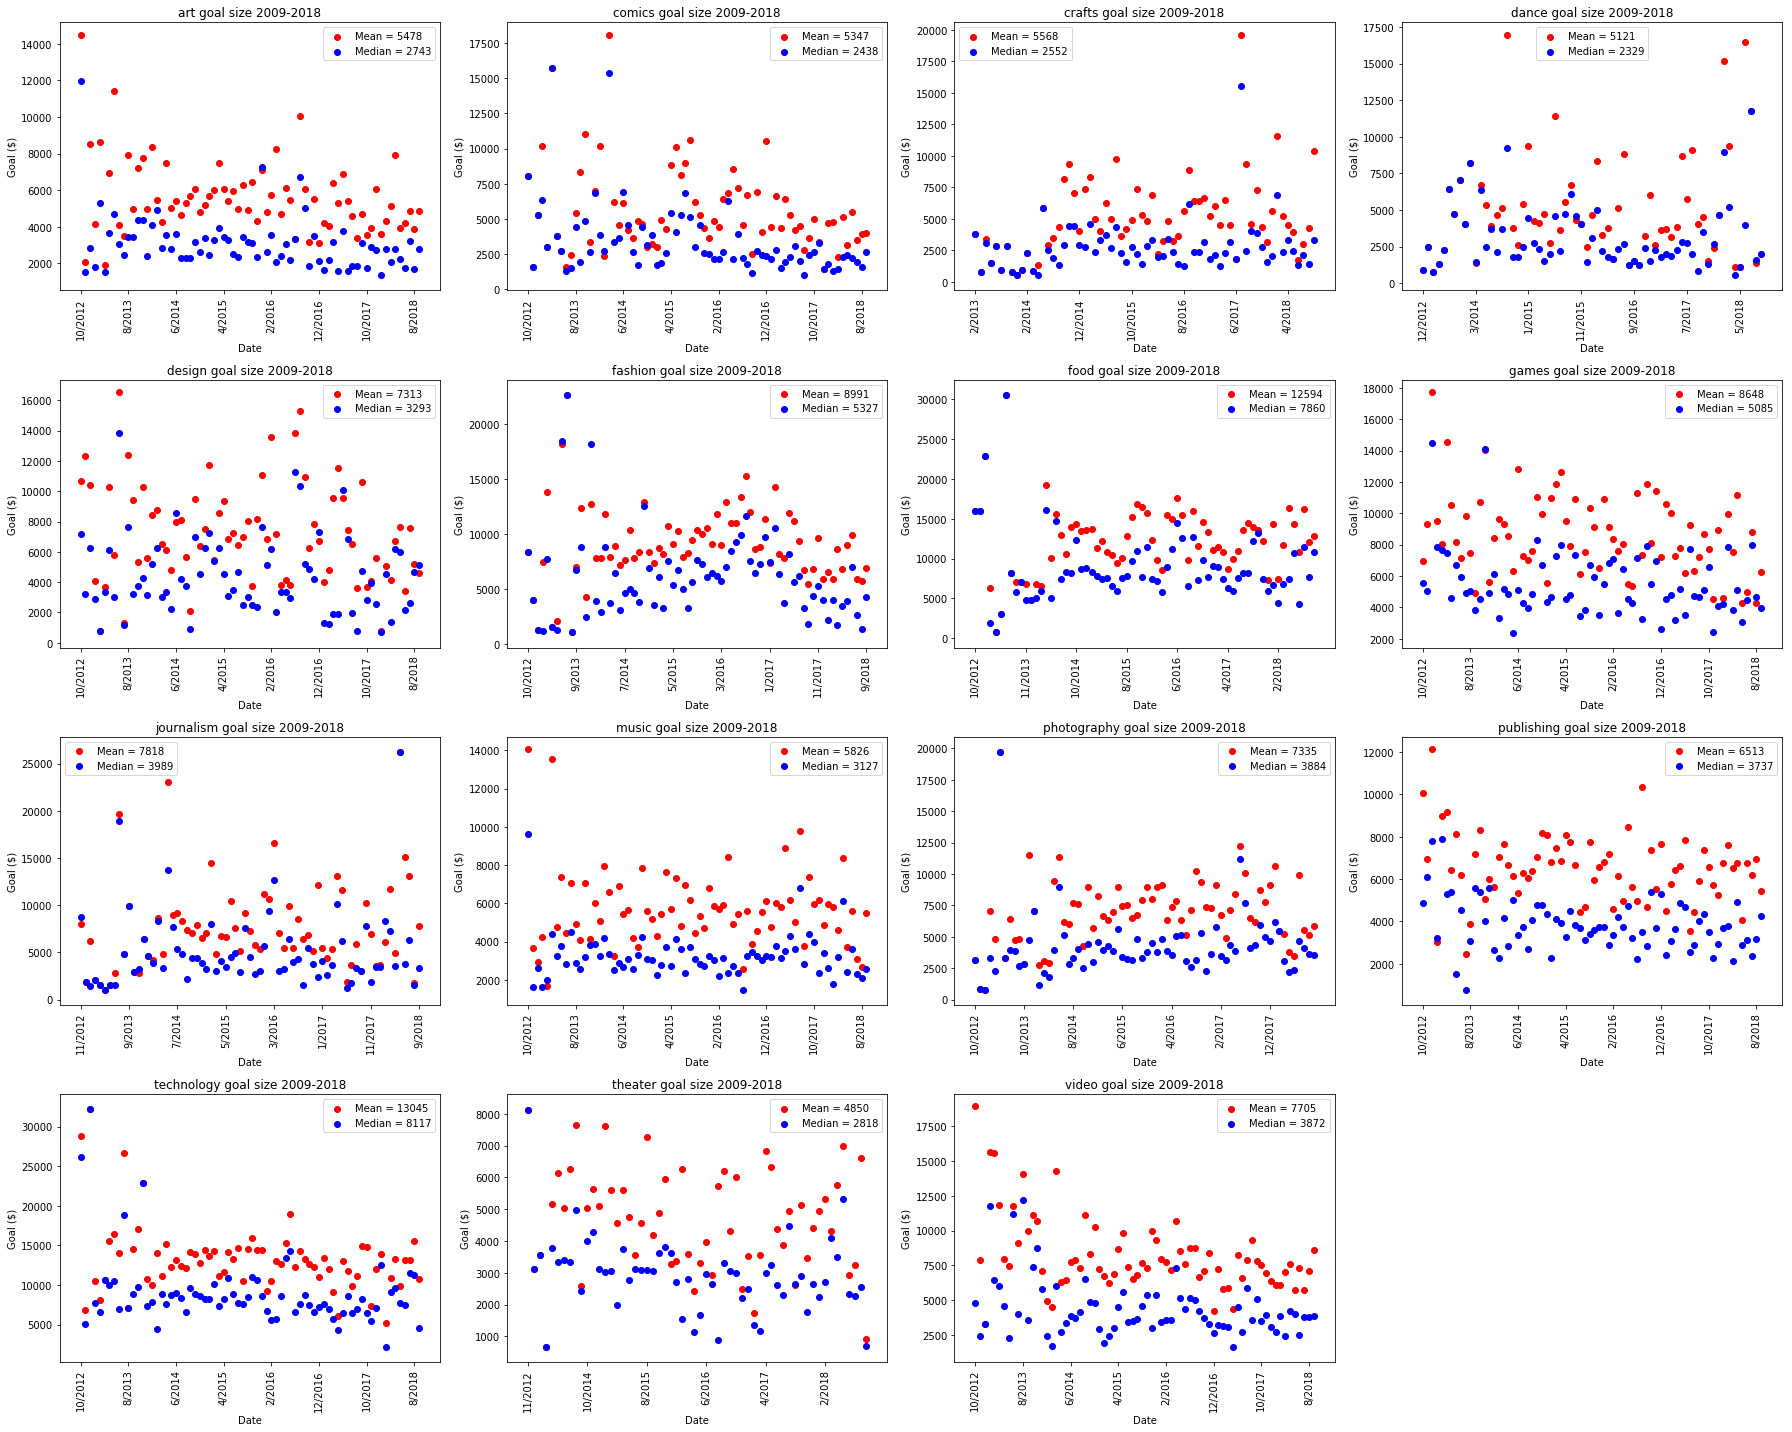

In [44]:
### GOAL SIZE PER CATEGORY

category_freq = df2_all['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_all.loc[df2_all['category'] == curr_category]
    category_goal_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_goal_dict[j] = temp1['goal']

    mean_category_goal_dict = {}
    median_category_goal_dict = {}
    for k,v in category_goal_dict.items():
        mean_category_goal_dict[k] = sum(v)/ len(v)
        median_category_goal_dict[k] = statistics.median(v)

    ordered_mean_category_goal_dict = dict(sorted(mean_category_goal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_goal_dict = dict(sorted(median_category_goal_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_goal_dict.keys()), list(ordered_mean_category_goal_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_goal_dict.keys()), list(ordered_median_category_goal_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('Goal ($)')
    mean = sum(temp['goal']) / len(temp['goal'])
    med = statistics.median(temp['goal'])
    plt.legend(['Mean = ' + str(round(mean)), 
                'Median = ' + str(round(med))], loc = 'best')
    plt.title(curr_category + ' goal size 2009-2018')

plt.tight_layout()
plt.show()

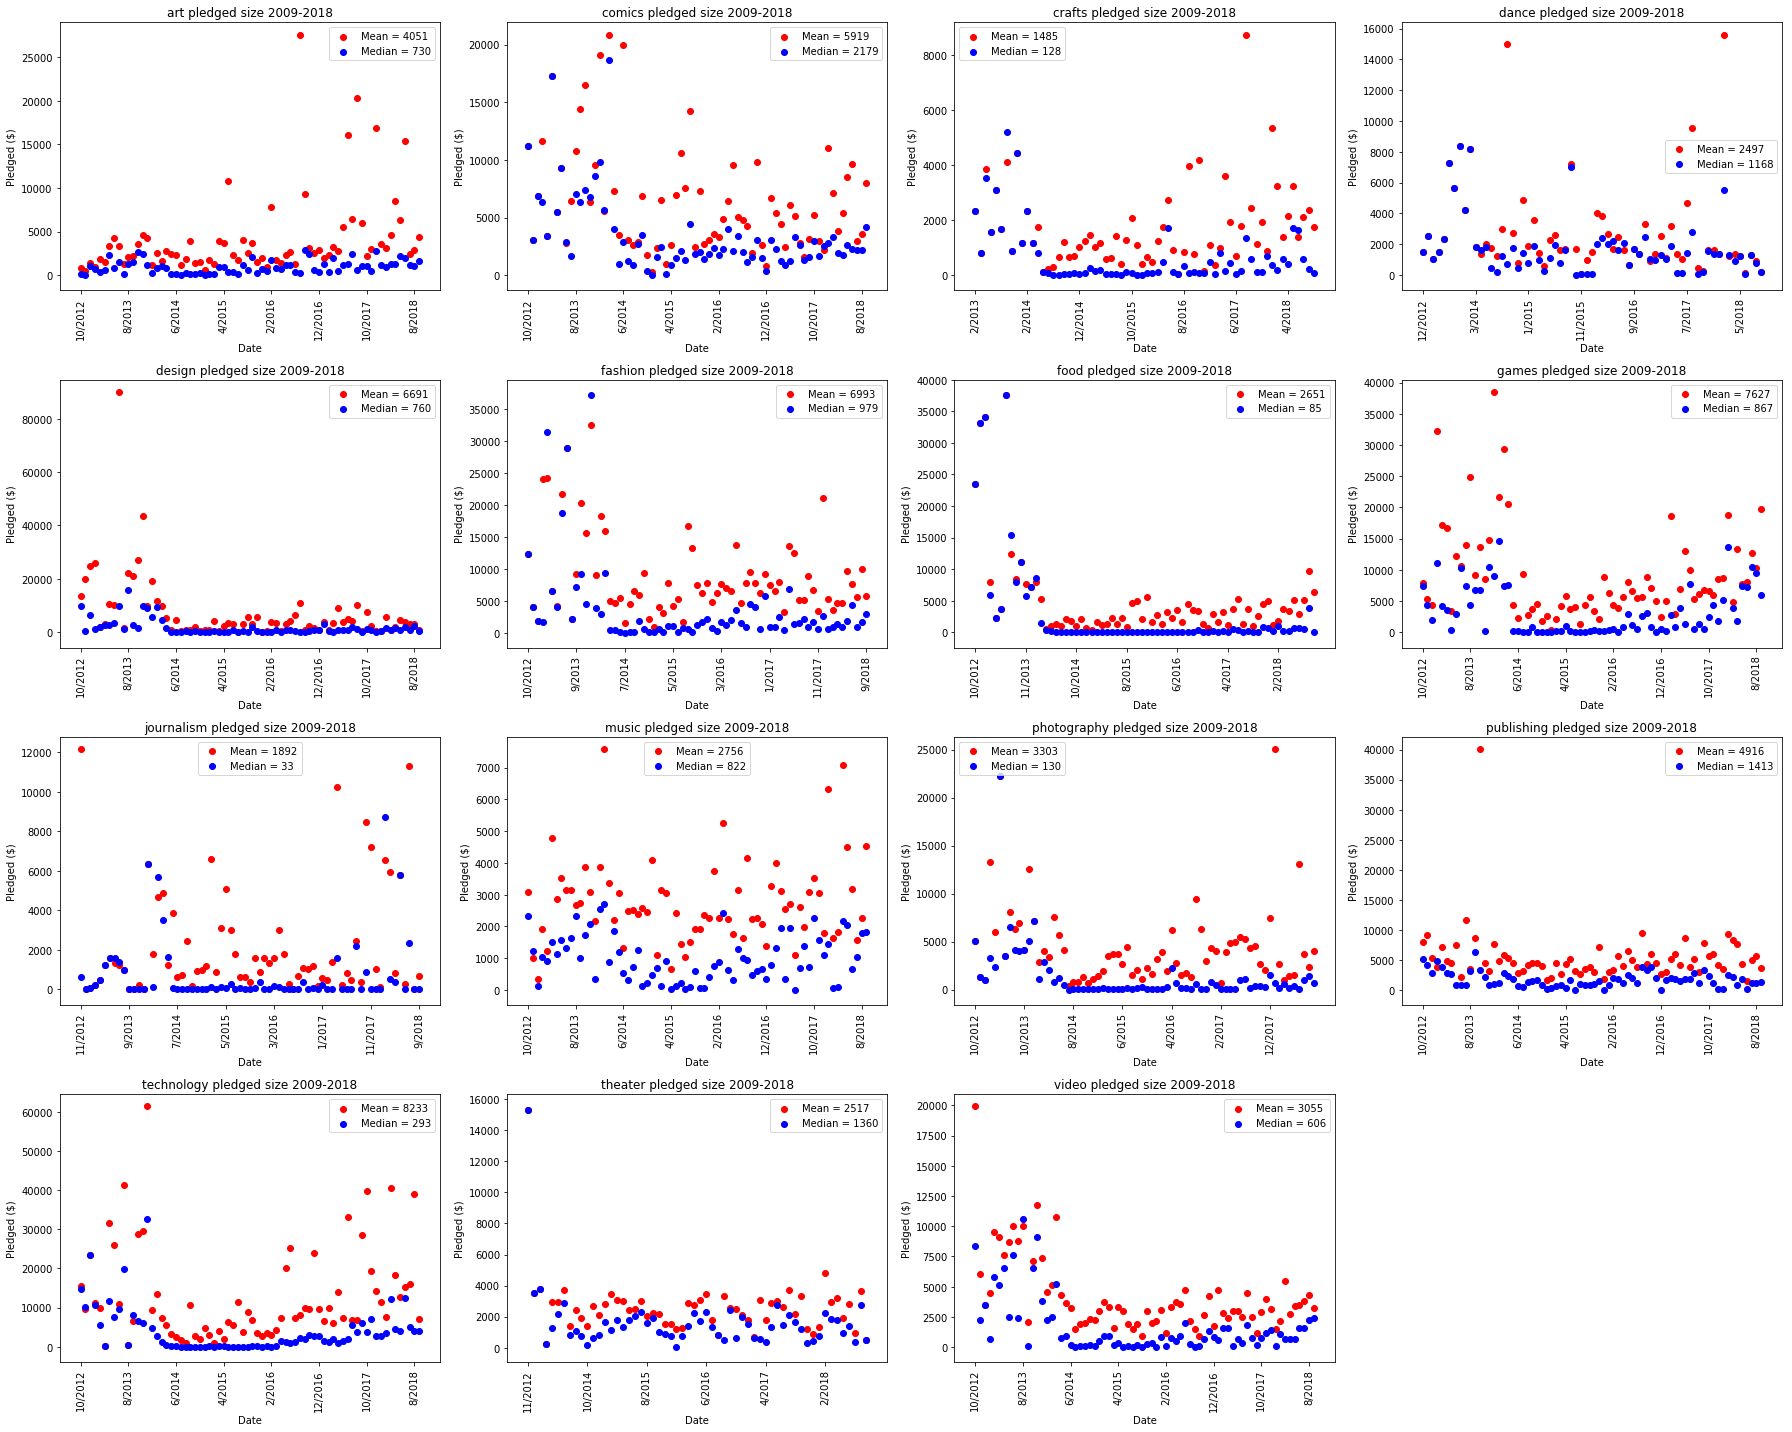

In [45]:
### PLEDGED SIZE PER CATEGORY

category_freq = df2_all['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_all.loc[df2_all['category'] == curr_category]
    category_pledged_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_pledged_dict[j] = temp1['usd_pledged']

    mean_category_pledged_dict = {}
    median_category_pledged_dict = {}
    for k,v in category_pledged_dict.items():
        mean_category_pledged_dict[k] = sum(v)/ len(v)
        median_category_pledged_dict[k] = statistics.median(v)

    ordered_mean_category_pledged_dict = dict(sorted(mean_category_pledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_pledged_dict = dict(sorted(median_category_pledged_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_pledged_dict.keys()), list(ordered_mean_category_pledged_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_pledged_dict.keys()), list(ordered_median_category_pledged_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('Pledged ($)')
    mean = sum(temp['usd_pledged']) / len(temp['usd_pledged'])
    med = statistics.median(temp['usd_pledged'])
    plt.legend(['Mean = ' + str(round(mean)), 
                'Median = ' + str(round(med))], loc = 'best')
    plt.title(curr_category + ' pledged size 2009-2018')

plt.tight_layout()
plt.show()

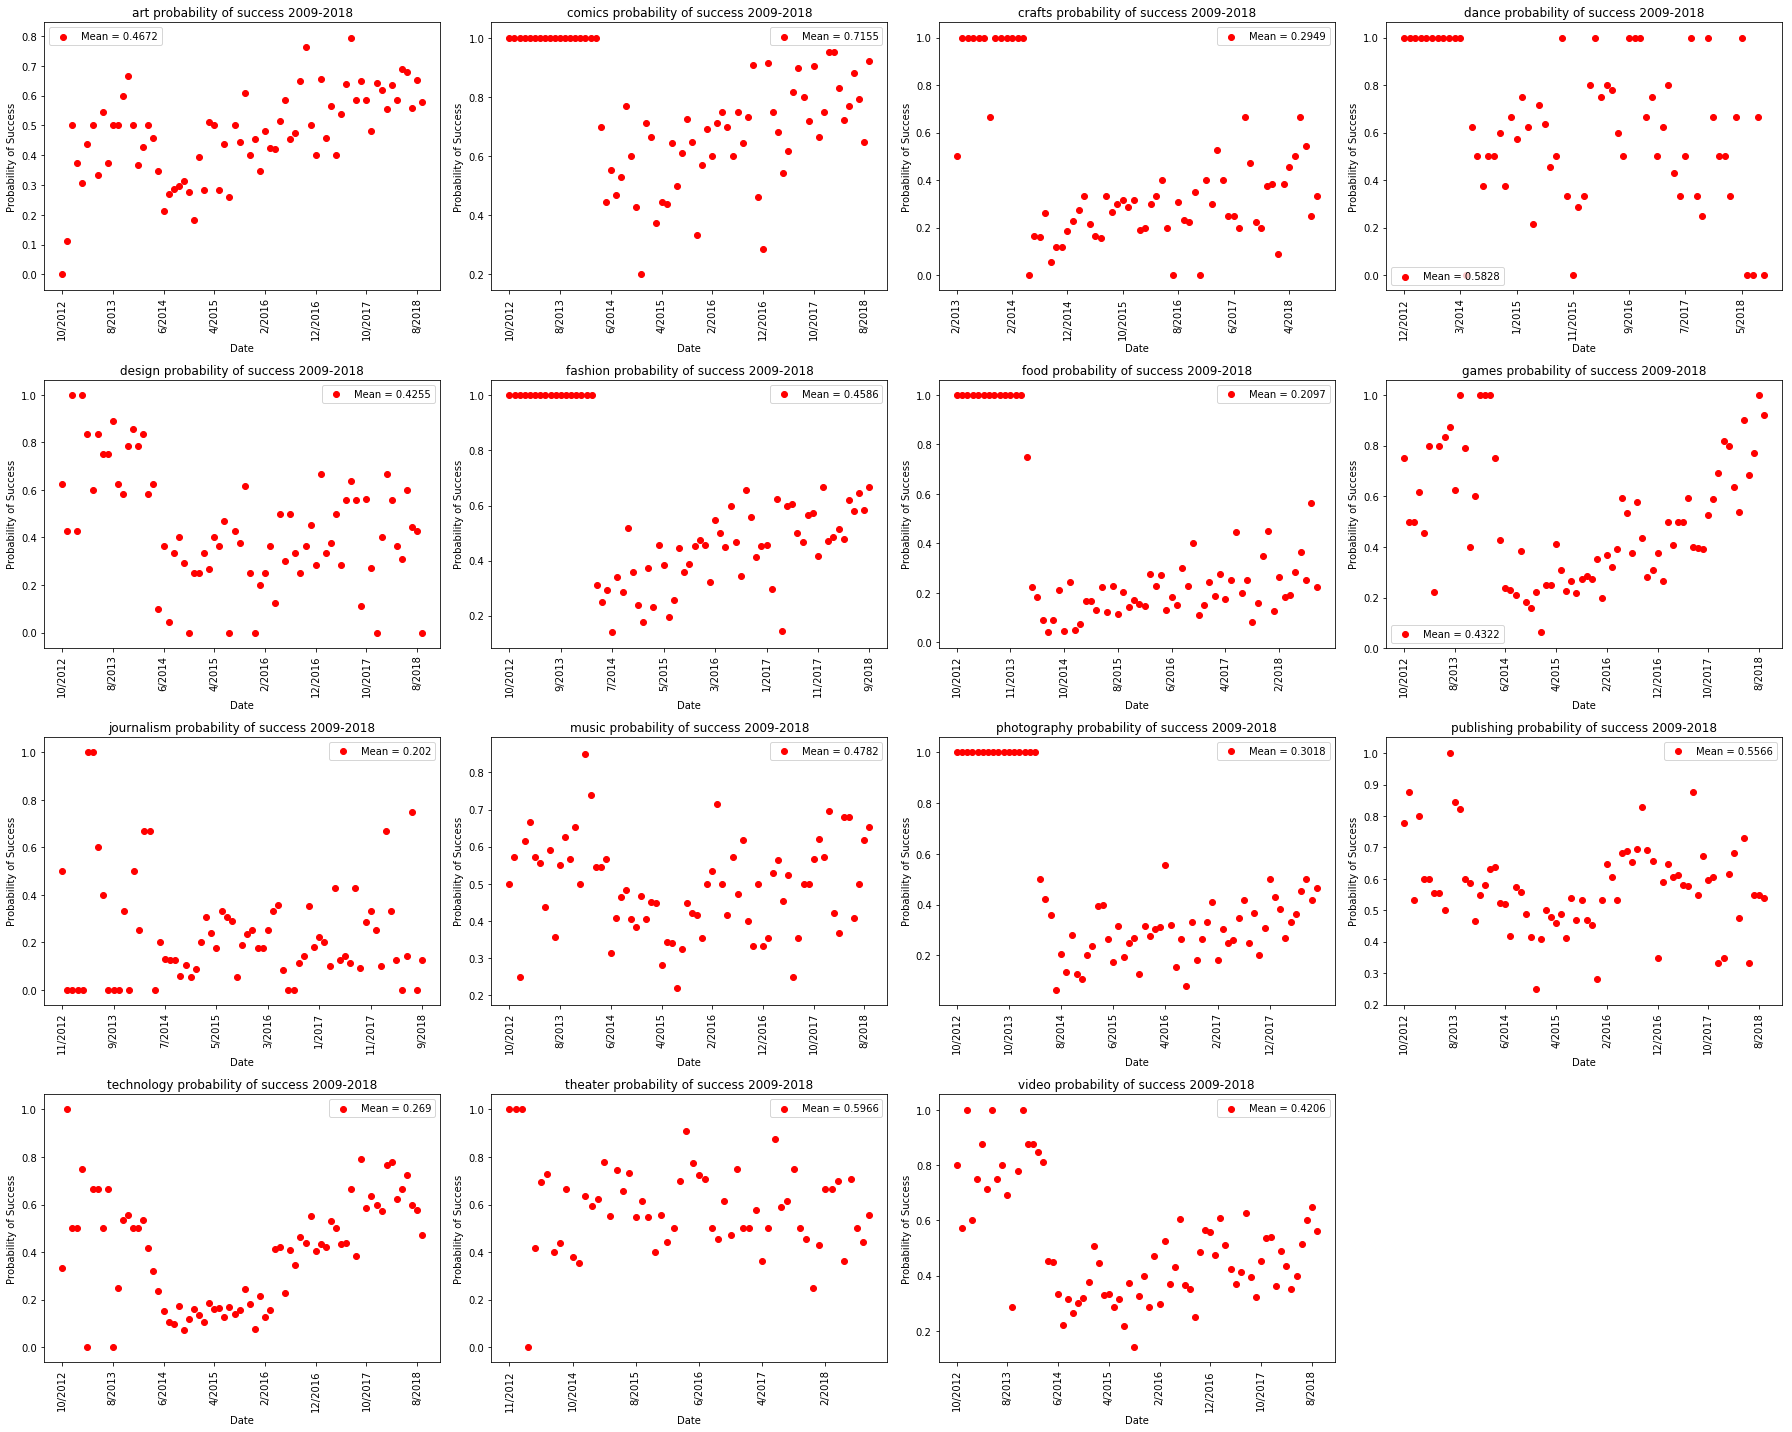

In [46]:
### PROB SUCCESS SIZE PER CATEGORY

category_freq = df2_all['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_all.loc[df2_all['category'] == curr_category]
    category_prob_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_prob_dict[j] = list(temp1['state'])

    mean_category_prob_dict = {}
    for k,v in category_prob_dict.items():
        sum_v = v.count('successful')
        mean_category_prob_dict[k] = sum_v / len(v)

    ordered_mean_category_prob_dict = dict(sorted(mean_category_prob_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))

    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_prob_dict.keys()), list(ordered_mean_category_prob_dict.values()), color = 'red')

    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('Probability of Success')
    sum_temp = list(temp['state']).count('successful')
    mean = sum_temp / len(temp['state'])
    plt.legend(['Mean = ' + str(round(mean, 4))], loc = 'best')
    plt.title(curr_category + ' probability of success 2009-2018')

plt.tight_layout()
plt.show()

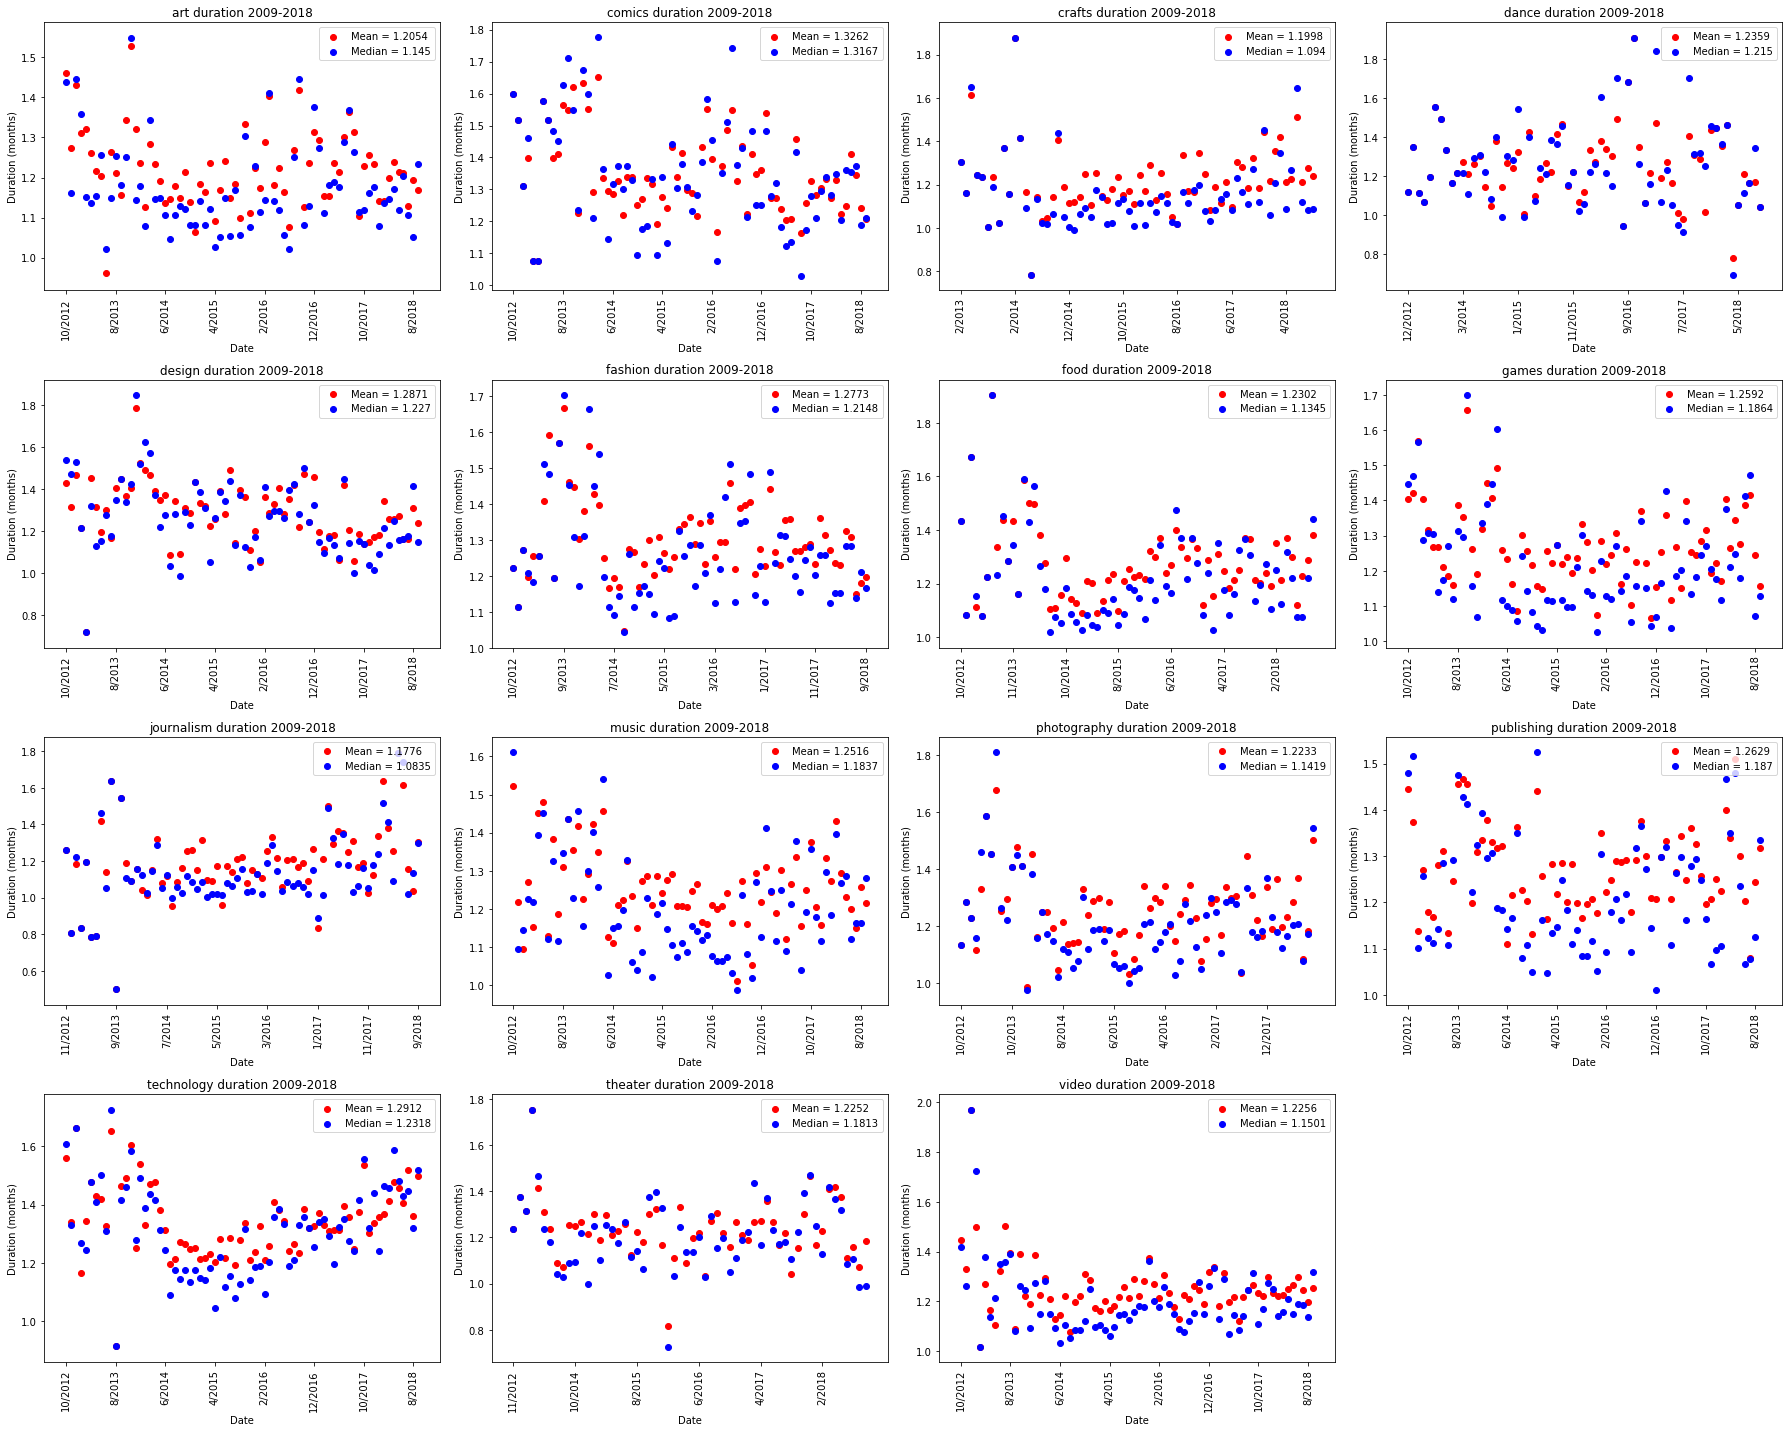

In [47]:
### DURATION PER CATEGORY
category_freq = df2_all['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())


fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_all.loc[df2_all['category'] == curr_category]
    category_duration_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_duration_dict[j] = temp1['duration']

    mean_category_duration_dict = {}
    median_category_duration_dict = {}
    for k,v in category_duration_dict.items():
        mean_category_duration_dict[k] = sum(v)/ len(v)
        median_category_duration_dict[k] = statistics.median(v)

    ordered_mean_category_duration_dict = dict(sorted(mean_category_duration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_duration_dict = dict(sorted(median_category_duration_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_duration_dict.keys()), list(ordered_mean_category_duration_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_duration_dict.keys()), list(ordered_median_category_duration_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('Duration (months)')
    mean = sum(temp['duration']) / len(temp['duration'])
    med = statistics.median(temp['duration'])
    plt.legend(['Mean = ' + str(round(mean, 4)), 
                'Median = ' + str(round(med, 4))], loc = 'upper right')
    plt.title(curr_category + ' duration 2009-2018')

plt.tight_layout()
plt.show()

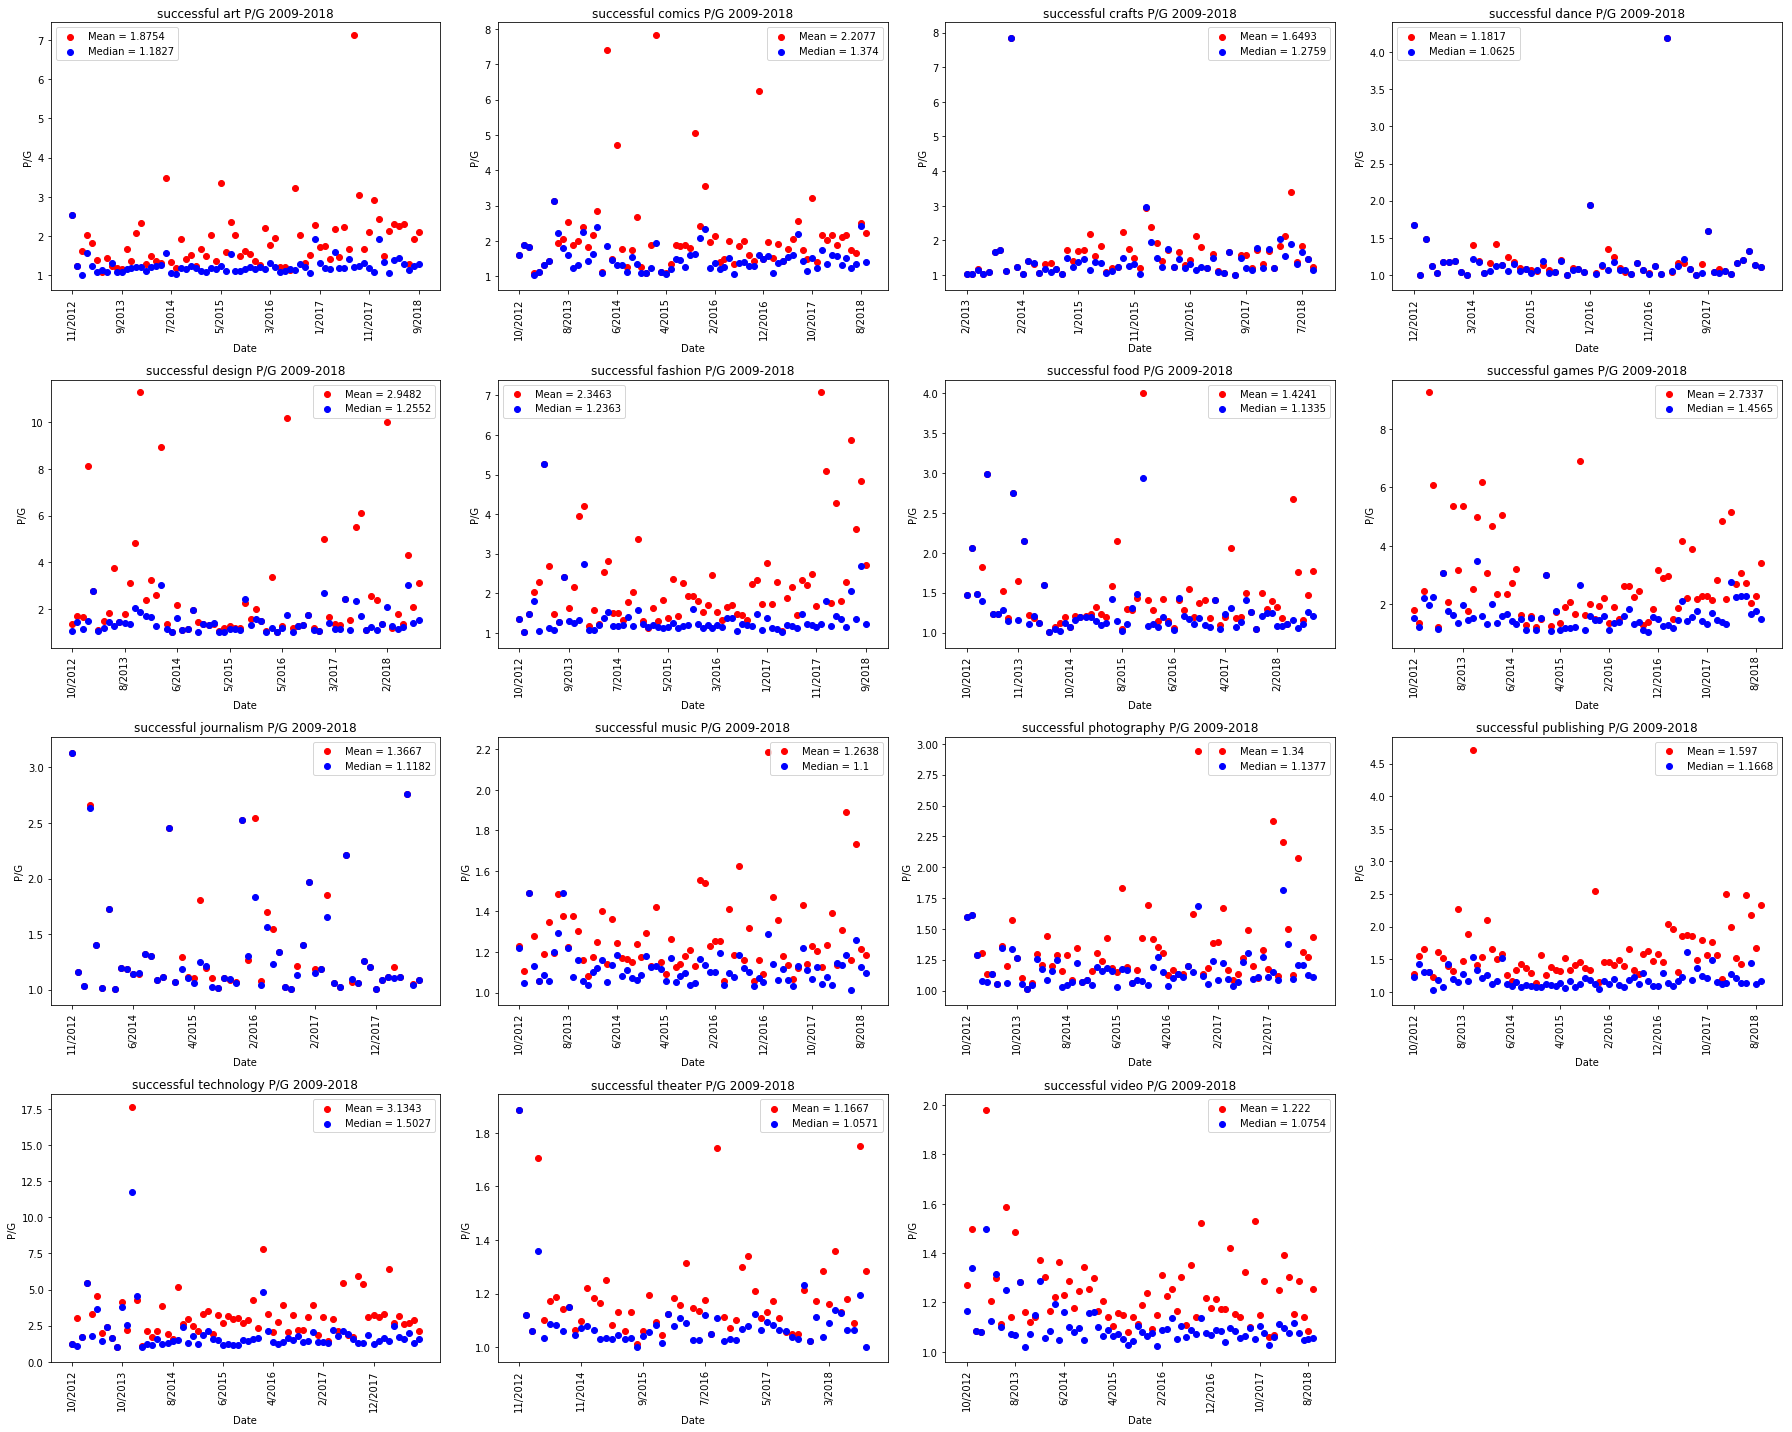

In [48]:
### SUCCESS P/G PER CATEGORY

category_freq = df2_success['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_success.loc[df2_success['category'] == curr_category]
    category_s_pg_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_s_pg_dict[j] = temp1['P/G']

    mean_category_s_pg_dict = {}
    median_category_s_pg_dict = {}
    for k,v in category_s_pg_dict.items():
        mean_category_s_pg_dict[k] = sum(v)/ len(v)
        median_category_s_pg_dict[k] = statistics.median(v)

    ordered_mean_category_s_pg_dict = dict(sorted(mean_category_s_pg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_s_pg_dict = dict(sorted(median_category_s_pg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_s_pg_dict.keys()), list(ordered_mean_category_s_pg_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_s_pg_dict.keys()), list(ordered_median_category_s_pg_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('P/G')
    mean = sum(temp['P/G']) / len(temp['P/G'])
    med = statistics.median(temp['P/G'])
    plt.legend(['Mean = ' + str(round(mean, 4)), 
                'Median = ' + str(round(med, 4))], loc = 'best')
    plt.title('successful ' + curr_category + ' P/G 2009-2018')

plt.tight_layout()
plt.show()

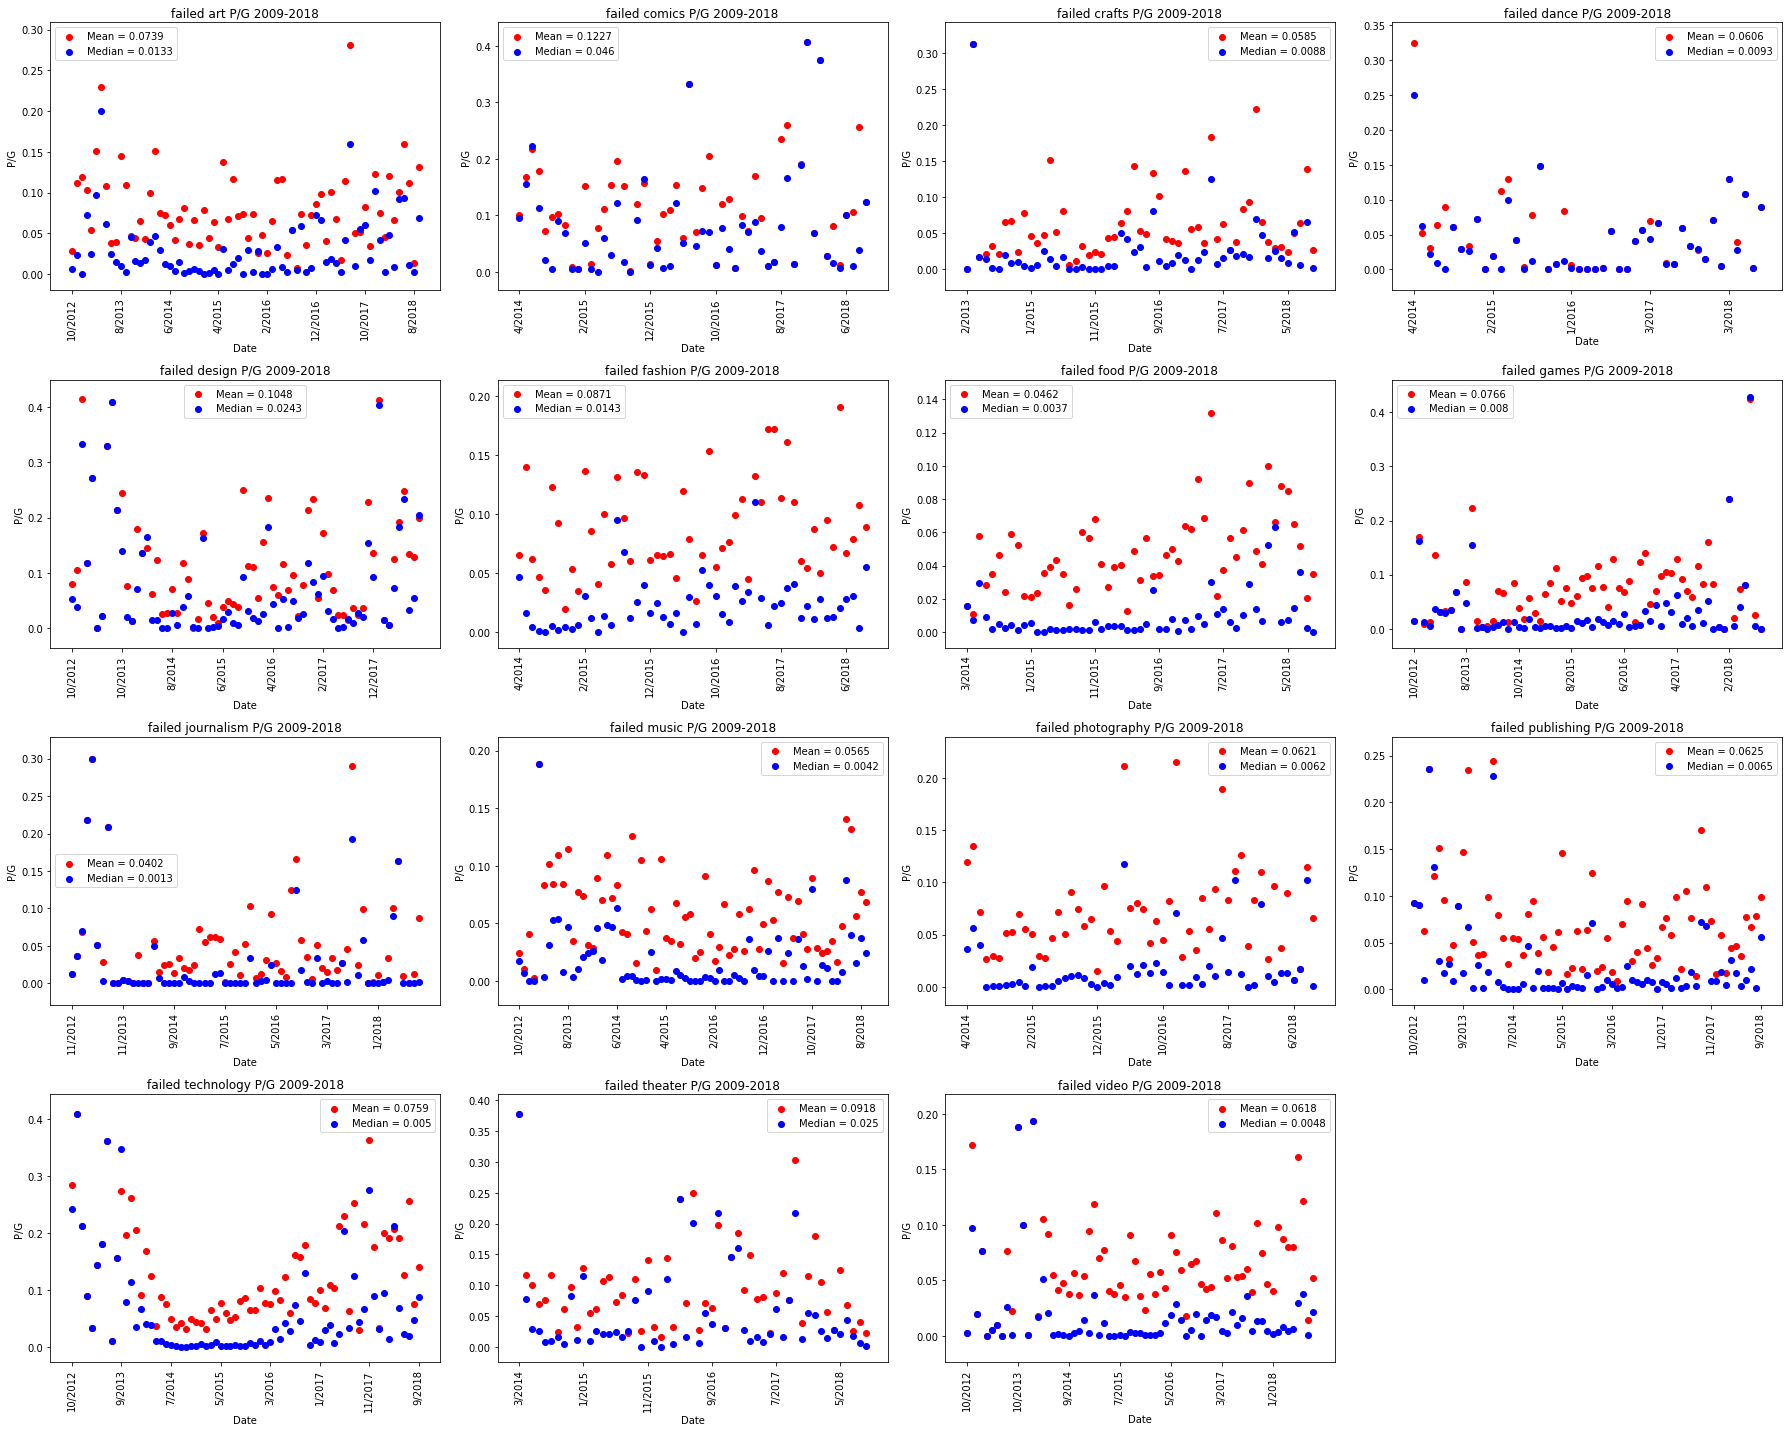

In [49]:
### FAIL P/G PER CATEGORY

category_freq = df2_fail['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_fail.loc[df2_fail['category'] == curr_category]
    category_f_pg_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_f_pg_dict[j] = temp1['P/G']

    mean_category_f_pg_dict = {}
    median_category_f_pg_dict = {}
    for k,v in category_f_pg_dict.items():
        mean_category_f_pg_dict[k] = sum(v)/ len(v)
        median_category_f_pg_dict[k] = statistics.median(v)

    ordered_mean_category_f_pg_dict = dict(sorted(mean_category_f_pg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_f_pg_dict = dict(sorted(median_category_f_pg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_f_pg_dict.keys()), list(ordered_mean_category_f_pg_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_f_pg_dict.keys()), list(ordered_median_category_f_pg_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('P/G')
    mean = sum(temp['P/G']) / len(temp['P/G'])
    med = statistics.median(temp['P/G'])
    plt.legend(['Mean = ' + str(round(mean, 4)), 
                'Median = ' + str(round(med, 4))], loc = 'best')
    plt.title('failed ' + curr_category + ' P/G 2009-2018')

plt.tight_layout()
plt.show()

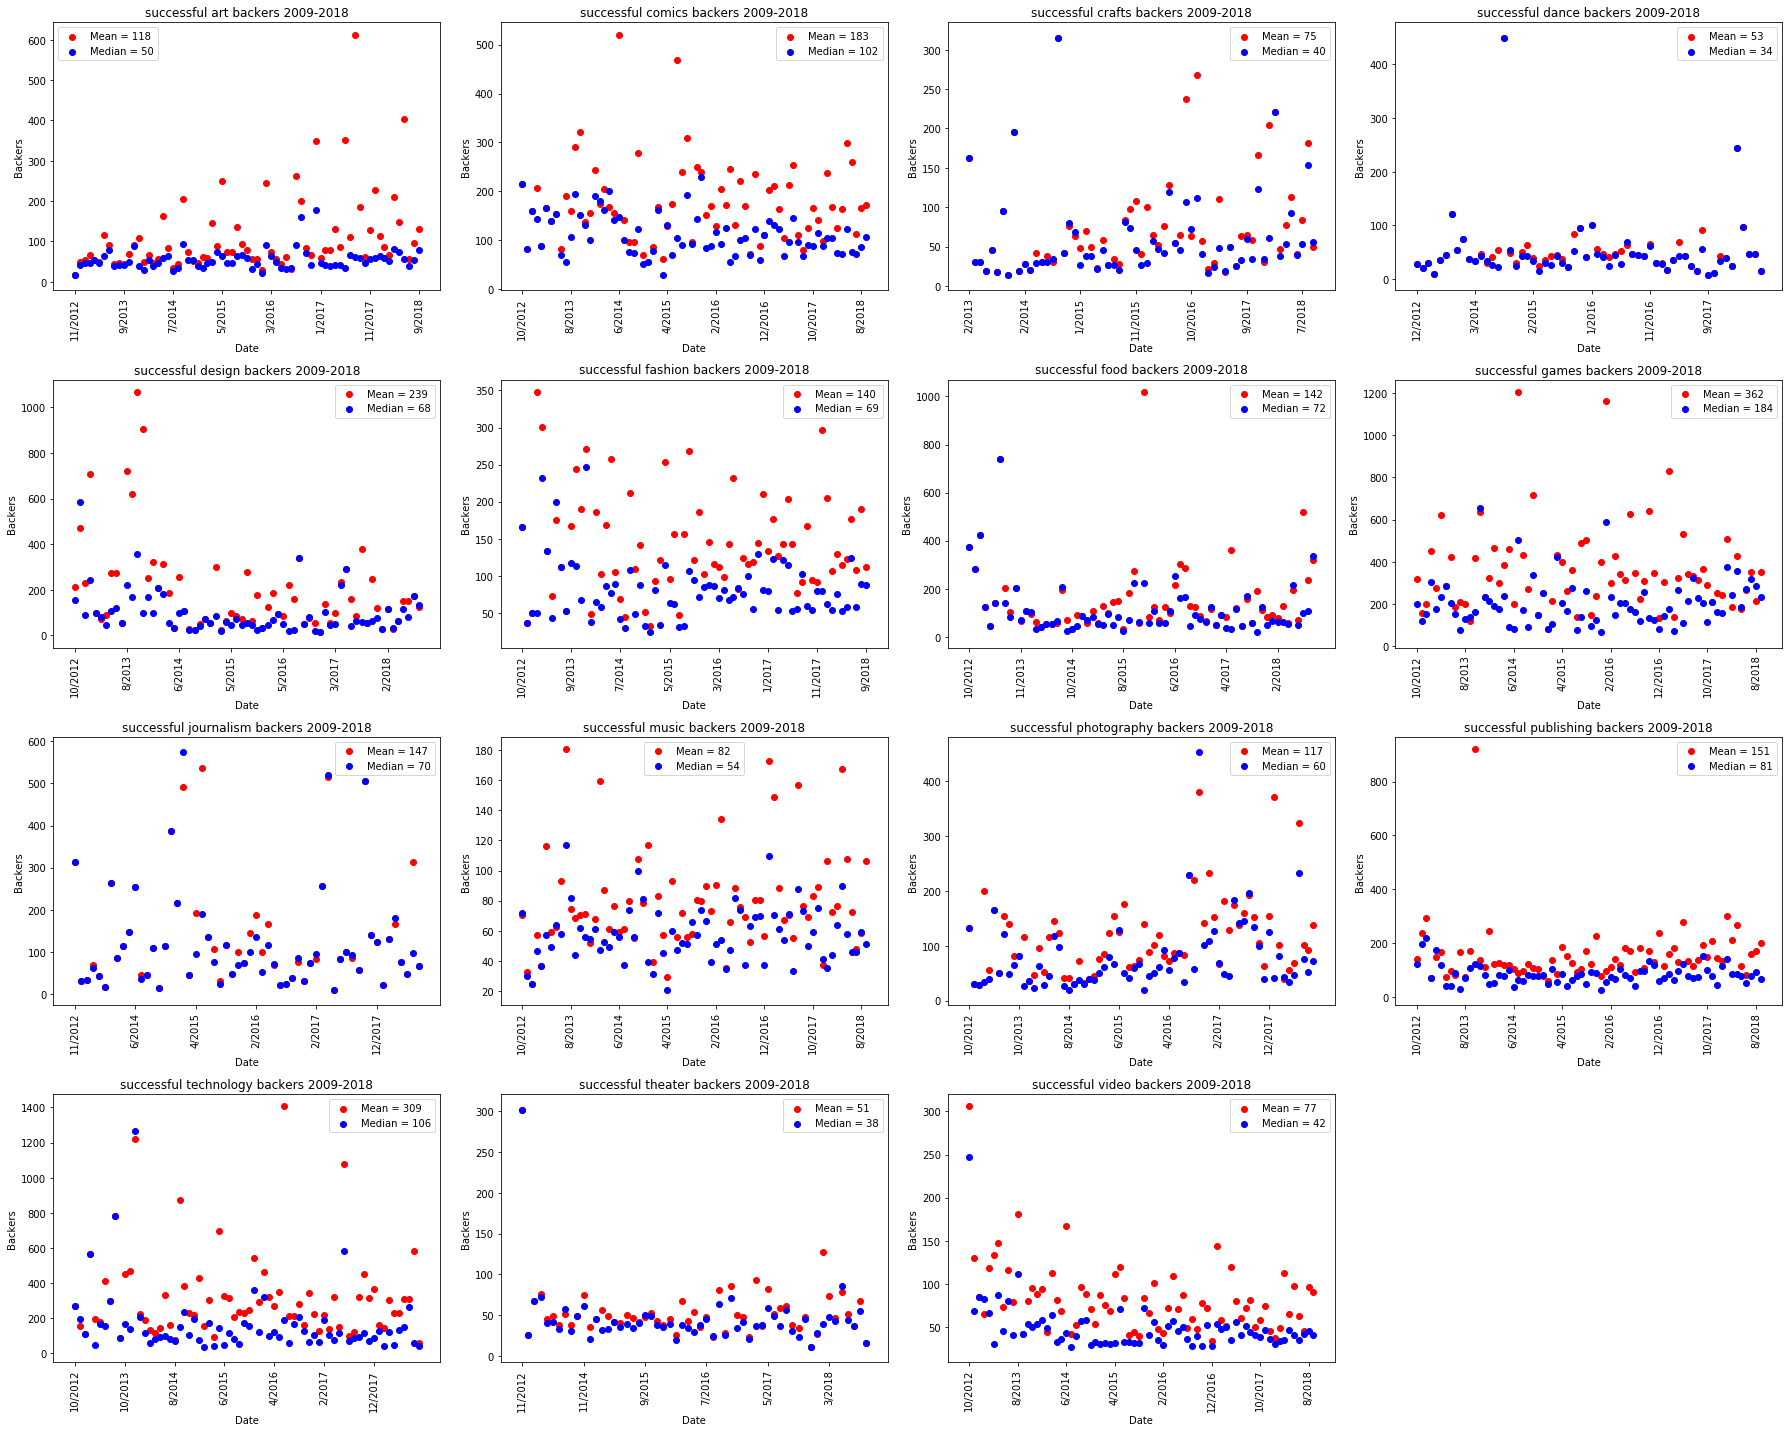

In [50]:
### SUCCESS BACKERS PER CATEGORY

category_freq = df2_success['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_success.loc[df2_success['category'] == curr_category]
    category_s_backers_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_s_backers_dict[j] = temp1['backers_count']

    mean_category_s_backers_dict = {}
    median_category_s_backers_dict = {}
    for k,v in category_s_backers_dict.items():
        mean_category_s_backers_dict[k] = sum(v)/ len(v)
        median_category_s_backers_dict[k] = statistics.median(v)

    ordered_mean_category_s_backers_dict = dict(sorted(mean_category_s_backers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_s_backers_dict = dict(sorted(median_category_s_backers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_s_backers_dict.keys()), list(ordered_mean_category_s_backers_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_s_backers_dict.keys()), list(ordered_median_category_s_backers_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('Backers')
    mean = sum(temp['backers_count']) / len(temp['backers_count'])
    med = statistics.median(temp['backers_count'])
    plt.legend(['Mean = ' + str(round(mean)), 
                'Median = ' + str(round(med))], loc = 'best')
    plt.title('successful ' + curr_category + ' backers 2009-2018')

plt.tight_layout()
plt.show()

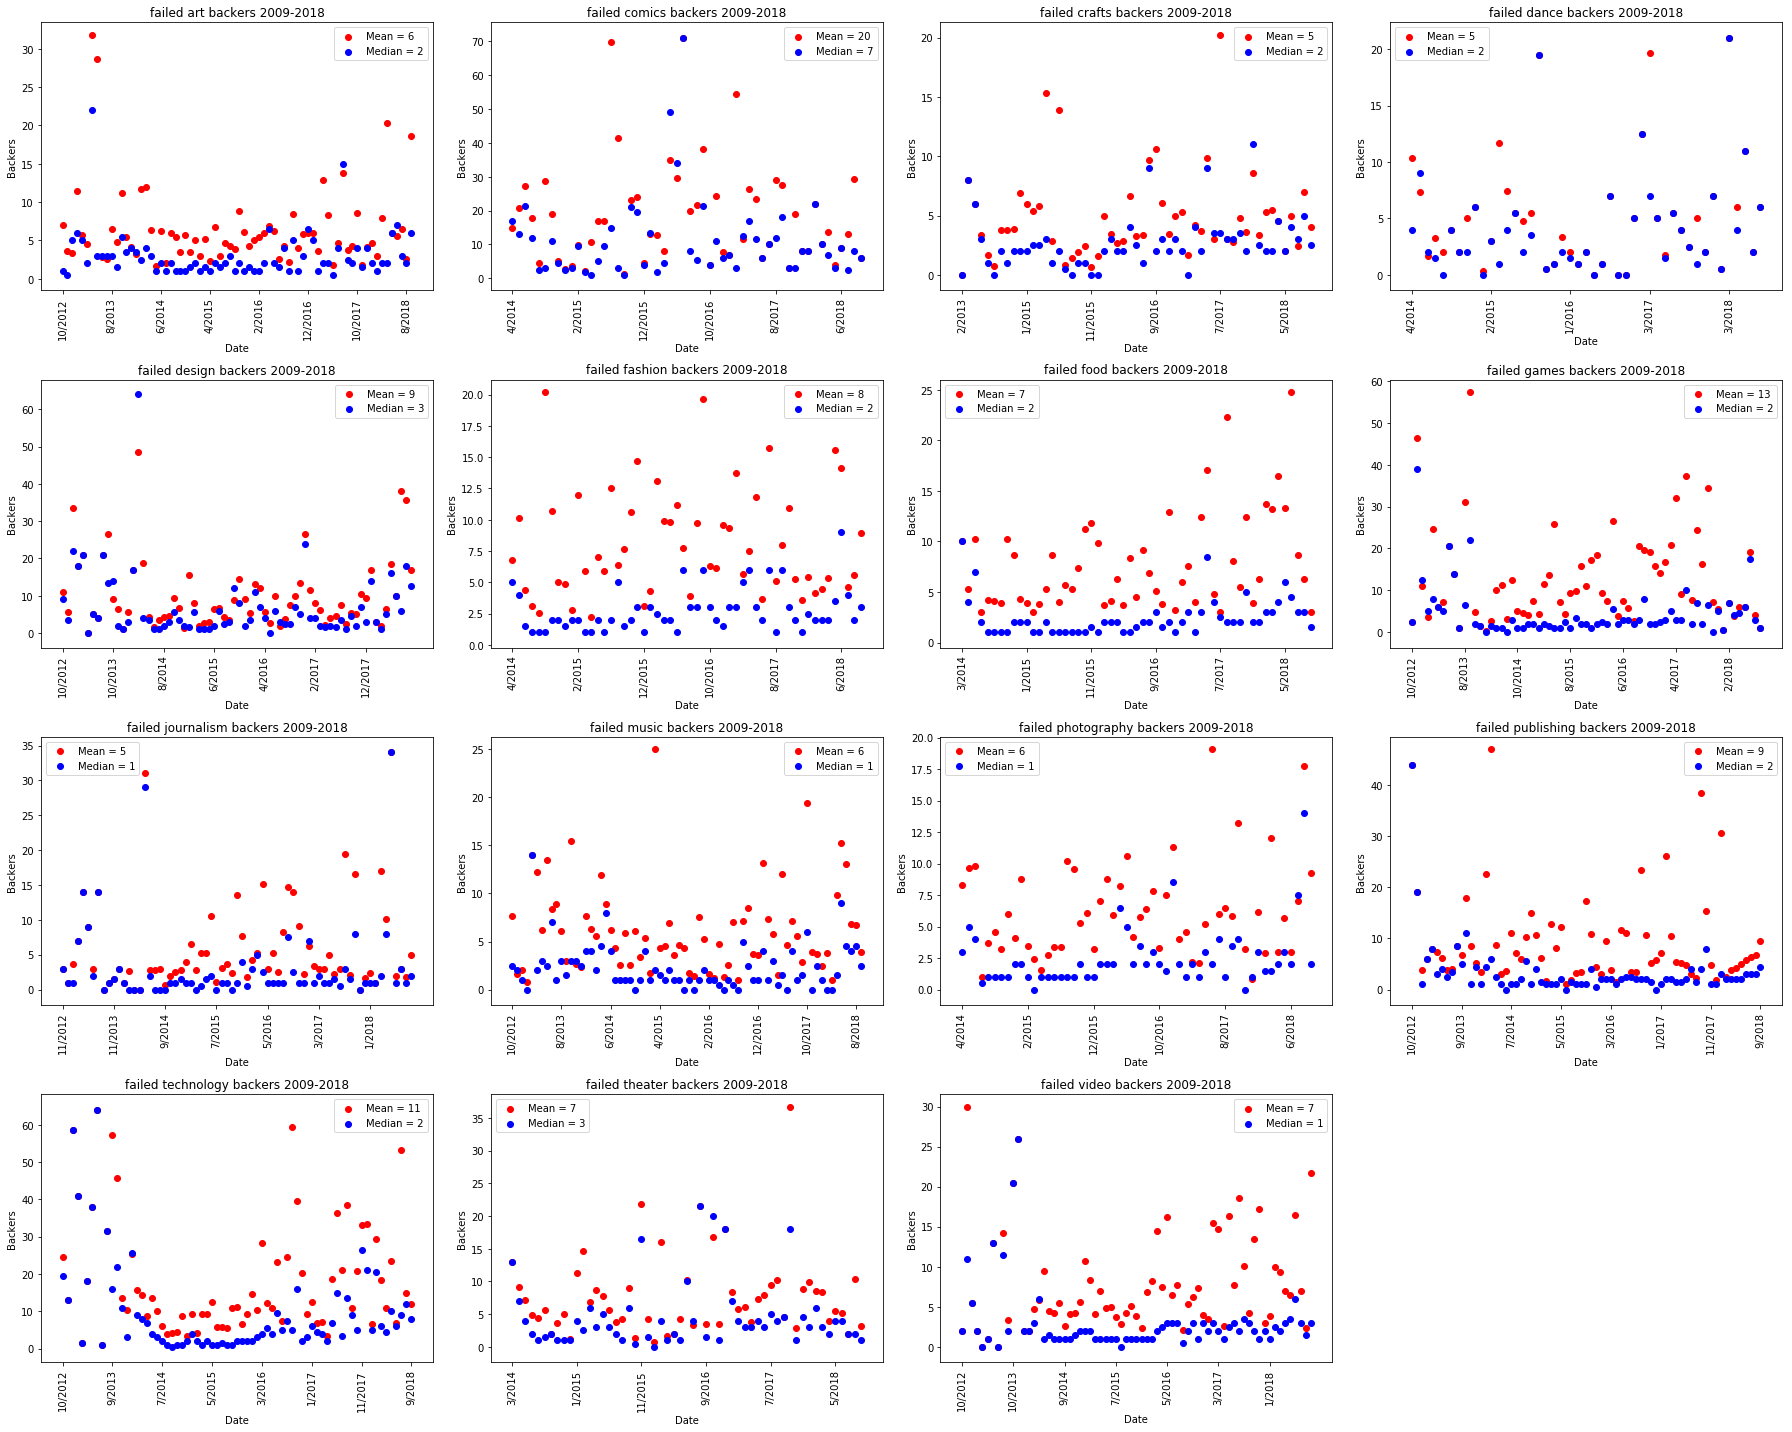

In [51]:
### FAIL BACKERS PER CATEGORY

category_freq = df2_fail['category'].value_counts().to_dict()
category_freq = dict(collections.OrderedDict(sorted(category_freq.items())))
category_keys = list(category_freq.keys())

fig = plt.figure(figsize=(25, 20))
for i in range(len(category_keys)):
    curr_category = category_keys[i]
    temp = df2_fail.loc[df2_fail['category'] == curr_category]
    category_f_backers_dict = {}
    
    curr_months = temp['Created At Month/Year'].value_counts().to_dict()
    for j in list(curr_months.keys()):
        temp1 = temp.loc[temp['Created At Month/Year'] == j]
        category_f_backers_dict[j] = temp1['backers_count']

    mean_category_f_backers_dict = {}
    median_category_f_backers_dict = {}
    for k,v in category_f_backers_dict.items():
        mean_category_f_backers_dict[k] = sum(v)/ len(v)
        median_category_f_backers_dict[k] = statistics.median(v)

    ordered_mean_category_f_backers_dict = dict(sorted(mean_category_f_backers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    ordered_median_category_f_backers_dict = dict(sorted(median_category_f_backers_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False))
    
    plt.subplot(4, 4, i+1)

    plt.scatter(list(ordered_mean_category_f_backers_dict.keys()), list(ordered_mean_category_f_backers_dict.values()), color = 'red')
    plt.scatter(list(ordered_median_category_f_backers_dict.keys()), list(ordered_median_category_f_backers_dict.values()), color = 'blue')
    
    locs, labs = plt.xticks() 
    plt.xticks(locs[0::10], rotation = 'vertical') 
    plt.xlabel('Date')
    plt.ylabel('Backers')
    mean = sum(temp['backers_count']) / len(temp['backers_count'])
    med = statistics.median(temp['backers_count'])
    plt.legend(['Mean = ' + str(round(mean)), 
                'Median = ' + str(round(med))], loc = 'best')
    plt.title('failed ' + curr_category + ' backers 2009-2018')

plt.tight_layout()
plt.show()

In [52]:
### SAVE DATAFRAMES

df2_all.to_pickle('../Desktop/saved_dataframes/Foreign_store_subset_allprojects.pkl')
df2_success.to_pickle('../Desktop/saved_dataframes/Foreign_store_subset_successprojects.pkl')
df2_fail.to_pickle('../Desktop/saved_dataframes/Foreign_store_subset_failprojects.pkl')